In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import sys
from pathlib import Path
# from my_kalman_filter import * 

# Extract manually input data from Excel

In [3]:
path = './data'

def list_files_with_extension(directory, extension):
    return [str(f) for f in Path(directory).glob(f'*{extension}') if f.is_file()]

In [4]:
excel_files = list_files_with_extension(path, '.xlsx')
if excel_files:
    excel_file = excel_files[0]
    df_excel = pd.read_excel(excel_file, sheet_name='All_Data')
else:
    df_excel = None

df_excel_clean = df_excel.copy()
df_excel_clean = df_excel_clean.rename(columns={"Condition": "condition", "V_housing": "Vhousing", "T_housing": "T_thermocouple",})

In [5]:
df_excel_clean

,T_thermocouple,Vhousing,condition
0,27.0,792,Open - heating
1,28.1,801,Open - heating
2,29.0,805,Open - heating
3,30.0,815,Open - heating
4,31.0,824,Open - heating
...,...,...,...
57,38.1,915,50C
58,39.2,926,50C
59,40.1,938,50C
60,41.1,946,50C


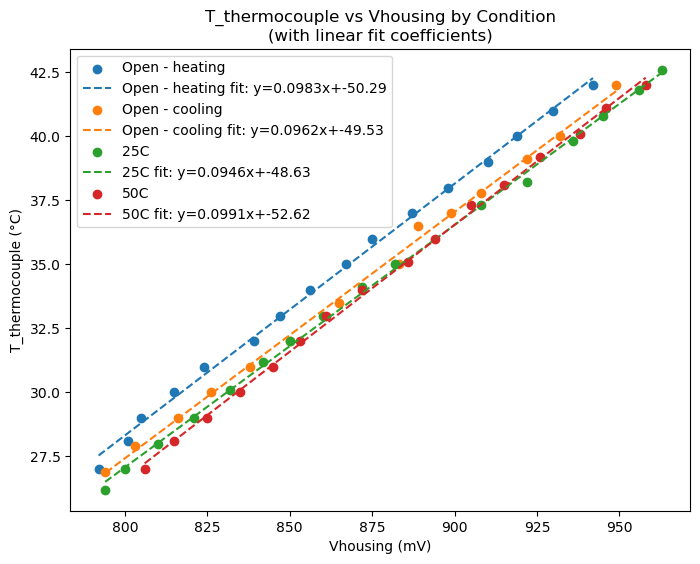

In [6]:
plt.figure(figsize=(8, 6))
colors = {'50°C': 'tab:blue', '25°C': 'tab:orange', 'OPEN': 'tab:green'}
unique_conditions = df_excel_clean['condition'].unique()

for cond in unique_conditions:
    mask = df_excel_clean['condition'] == cond
    x = df_excel_clean.loc[mask, 'Vhousing']
    y = df_excel_clean.loc[mask, 'T_thermocouple']
    plt.scatter(x, y, label=cond, color=colors.get(cond, None))
    # Linear regression for this condition
    if len(x) > 1:
        model = LinearRegression()
        model.fit(x.values.reshape(-1, 1), y.values)
        slope = model.coef_[0]
        intercept = model.intercept_
        plt.plot(x, model.predict(x.values.reshape(-1, 1)), color=colors.get(cond, None), linestyle='--',
                 label=f"{cond} fit: y={slope:.3g}x+{intercept:.2f}")

# # Linear regression for all data
# x_all = df_excel_clean['Vhousing'].values.reshape(-1, 1)
# y_all = df_excel_clean['T_thermocouple'].values
# model_all = LinearRegression()
# model_all.fit(x_all, y_all)
# slope_all = model_all.coef_[0]
# intercept_all = model_all.intercept_
# plt.plot(df_excel_clean['Vhousing'], model_all.predict(x_all), color='k', linestyle='--',
#          label=f"All data fit: y={slope_all:.3g}x+{intercept_all:.2f}")

plt.xlabel('Vhousing (mV)')
plt.ylabel('T_thermocouple (°C)')
plt.legend()
plt.title('T_thermocouple vs Vhousing by Condition\n(with linear fit coefficients)')
plt.show()

In [7]:
# Mask for 'OPEN' condition in df_excel_clean
mask_open = df_excel_clean['condition'] == 'Open - heating'
x_open = df_excel_clean.loc[mask_open, 'Vhousing'].values.reshape(-1, 1)
y_open = df_excel_clean.loc[mask_open, 'T_thermocouple'].values

# Fit linear regression for OPEN data
model_open = LinearRegression()
model_open.fit(x_open, y_open)
slope_open = model_open.coef_[0]
intercept_open = model_open.intercept_

# Import the Display Readings

In [8]:
def extract_data_inline(filename):
    """
    Extract data from a text file generated by makerplot or equivalent, adapted for your column structure.
    Args:
        filename: The text file containing the data to extract.
    Returns:
        idx_start: Index of start of burn.
        idx_stop: Index of stop of burn.
        delta_time: Median time difference between records.
        T : DataFrame of temperatures.
        X : DataFrame of voltages and other signals.
    """
    data = pd.read_table(filename, delimiter=',')
    
    # Identify start and stop indices for the burn using 'power_flag'
    idx_start = np.where(np.diff(np.insert(data['power_flag'].values, 0, 0)) == 1)[0].tolist()
    idx_stop = np.where(np.diff(np.append(data['power_flag'].values, 0)) == -1)[0].tolist()
    
    # Extract voltages and other signals
    V_rad_short = data['V_radshort'].to_numpy()
    V_rad_tot = data['V_radtotal'].to_numpy()
    V_housing = data['V_housing'].to_numpy()
    V_diode = data['V_diode'].to_numpy()
    V_spike = data['VTC2'].to_numpy()
 
    
    # Cooling flags
    cooling_flag_1 = data['antenna_cooling_flag'].to_numpy() if 'antenna_cooling_flag' in data.columns else [float('nan')] * len(data)
    cooling_flag_2 = data['switch_cooling_flag'].to_numpy() if 'switch_cooling_flag' in data.columns else [float('nan')] * len(data)
    # print(data.Time)
    power = data['Power'].to_numpy() * (data['power_flag'] > 0).astype(float)

    delta_time = np.median(np.diff(data['Time'].astype(float).values))
    
    # Temperatures (using VTC2 as T_housing, V_diode as T_diode, V_probe as T_display)
    T = pd.DataFrame({
        'T_antenna': [float('nan')] * len(data),  # Not available in your columns
        'T_diode': V_diode,
        'T_housing': data['VTC2'].to_numpy(),
        'T_display': data['V_probe'].to_numpy()
    })
    
    X = pd.DataFrame({
        'V_rad_short': V_rad_short,
        'V_rad_tot': V_rad_tot,
        'V_housing': V_housing,
        'V_diode': V_diode,
        'V_spike': V_spike,
        'cooling_flag_1': cooling_flag_1,
        'cooling_flag_2': cooling_flag_2,
        'power': power
    })
    
    return idx_start, idx_stop, delta_time, T, X

In [9]:
txt_files = list_files_with_extension(path, '.txt')

In [10]:
# Add a 'time_index' column before concatenating all_X
all_X = []

for file in txt_files:
    # Extract condition (text after last underscore, before .txt)
    condition = Path(file).stem.split('_')[-1]
    # Extract data
    _, _, _, _, X_local = extract_data_inline(file)
    # Drop unwanted columns
    X_local = X_local.drop(columns=['cooling_flag_1', 'cooling_flag_2', 'power'])
    # Add time_index column
    X_local = X_local.copy()
    X_local['time_index'] = X_local.index
    # Add condition column
    X_local['condition'] = condition
    all_X.append(X_local)

all_X = pd.concat(all_X, ignore_index=True)

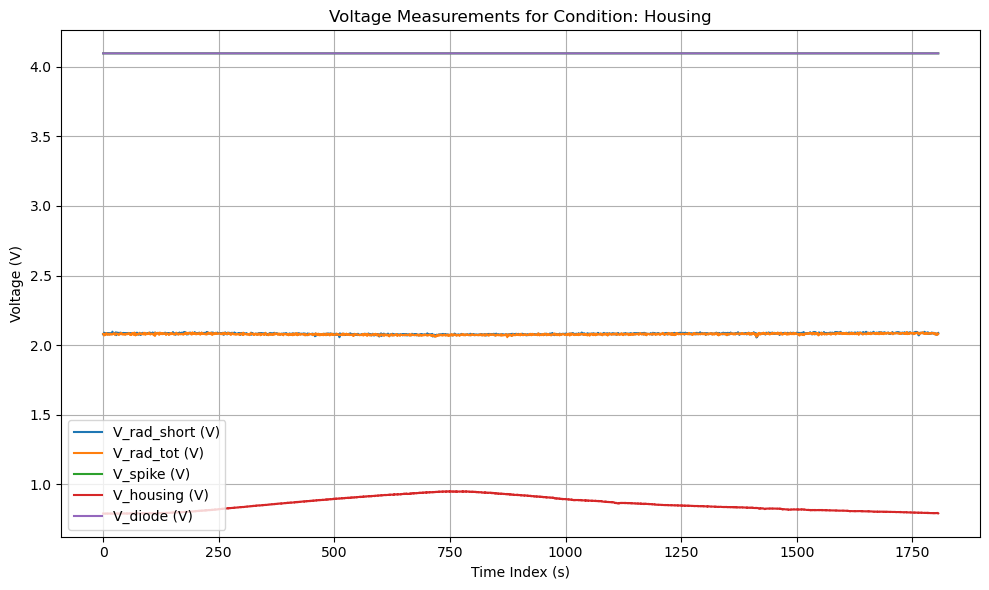

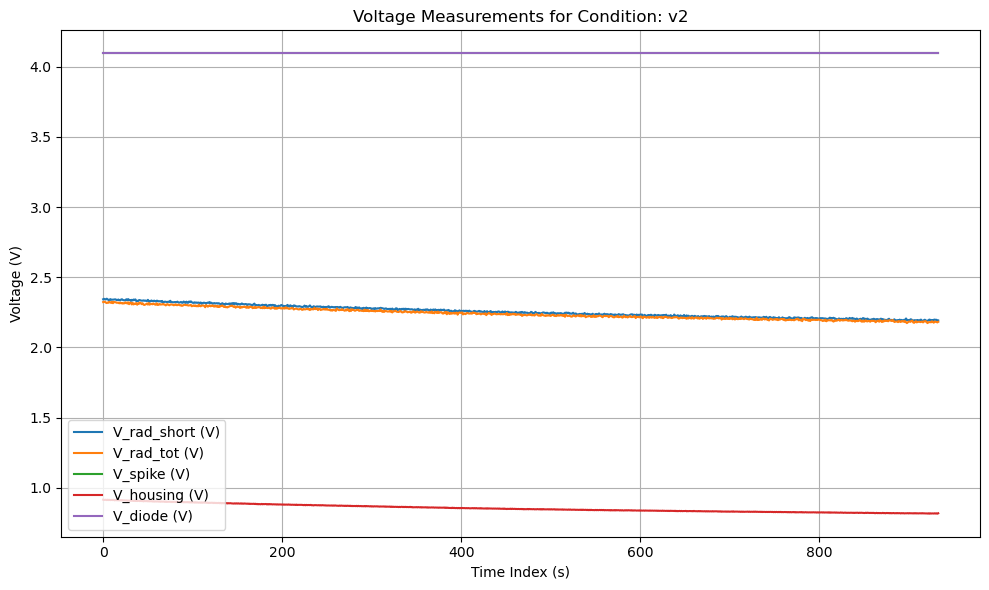

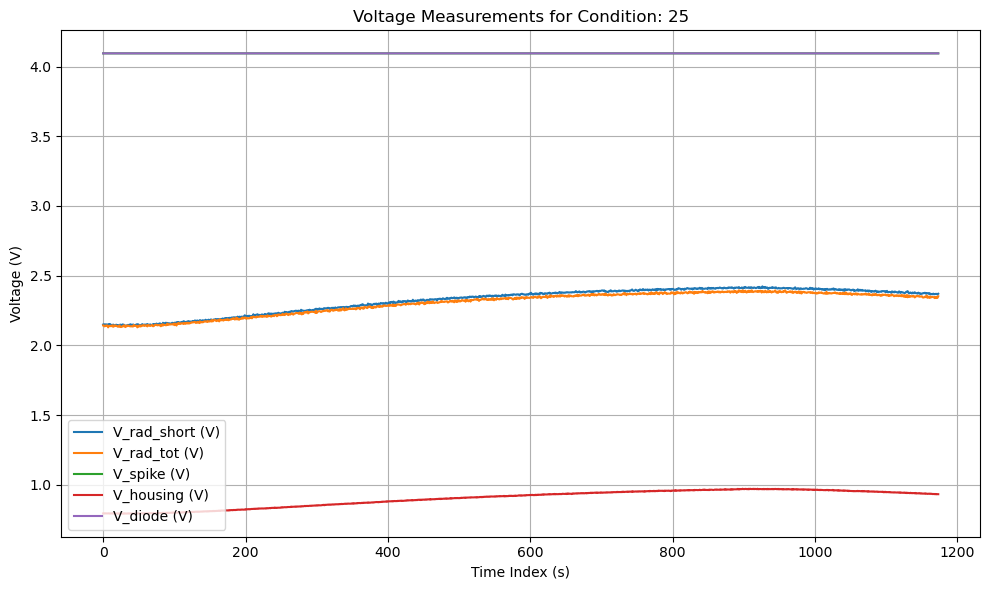

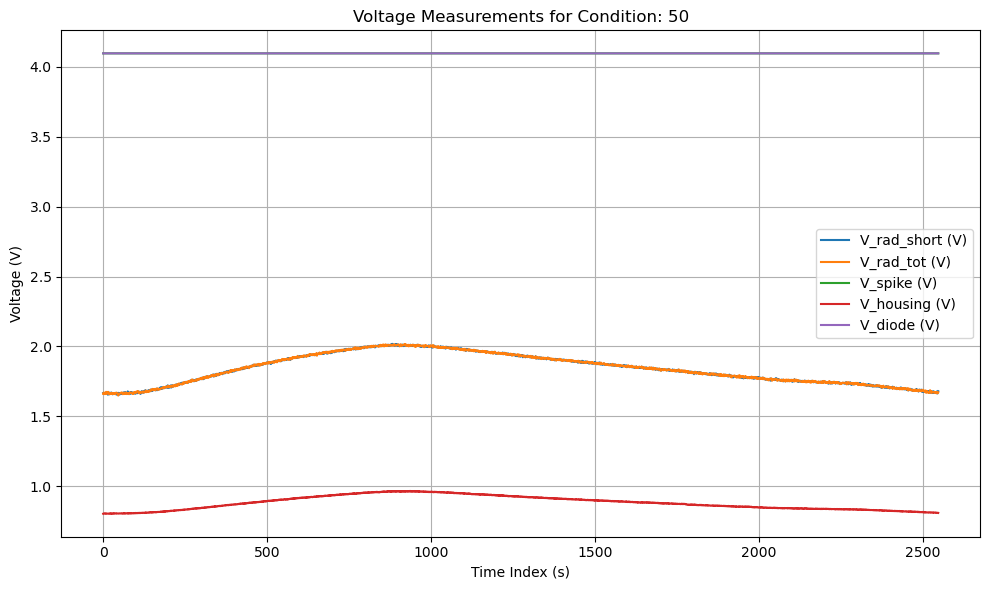

In [11]:
# Plot V_rad_short, V_rad_tot, V_spike, V_housing, V_diode vs sample index for each condition

variables = ['V_rad_short', 'V_rad_tot', 'V_spike', 'V_housing', 'V_diode']
labels = {
    'V_rad_short': 'V_rad_short (V)',
    'V_rad_tot': 'V_rad_tot (V)',
    'V_spike': 'V_spike (V)',
    'V_housing': 'V_housing (V)',
    'V_diode': 'V_diode (V)'
}

for cond in all_X['condition'].unique():
    subset = all_X[all_X['condition'] == cond]
    plt.figure(figsize=(10, 6))
    for var in variables:
        plt.plot(subset.time_index, subset[var] / 1000, label=labels[var])
    plt.title(f"Voltage Measurements for Condition: {cond}")
    plt.xlabel("Time Index (s)")
    plt.ylabel("Voltage (V)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Change the data in the different conditions to these updated conditions:
* the condition Housing with time index < 750 to open-heating
* the condition Housing with time index > 750 to open-cooling (restart the time index)
* the condition 25  with time index < 900 to 25C-heating
* the condition 25 with time index > 900 to 25C-cooling (restart time index)
* the condition v2 to 25C-cooling (concatenate time index with previous)
* the condition 50  with time index < 900 to 50C-heating
* the condition 50 with time index > 900 to 50C-cooling (restart time index)

In [12]:
# Copy all_X to avoid modifying the original
all_X_renamed = all_X.copy()

# 1. Housing
mask_housing = all_X_renamed['condition'].str.lower() == 'housing'
mask_housing_heating = mask_housing & (all_X_renamed['time_index'] < 750)
mask_housing_cooling = mask_housing & (all_X_renamed['time_index'] >= 750)

all_X_renamed.loc[mask_housing_heating, 'condition'] = 'open-heating'
all_X_renamed.loc[mask_housing_cooling, 'condition'] = 'open-cooling'
# Restart time_index for open-cooling
if mask_housing_cooling.any():
    idxs = all_X_renamed[mask_housing_cooling].index
    all_X_renamed.loc[idxs, 'time_index'] = range(len(idxs))

# 2. 25
mask_25c = all_X_renamed['condition'].str.lower() == '25'
mask_25c_heating = mask_25c & (all_X_renamed['time_index'] < 900)
mask_25c_cooling = mask_25c & (all_X_renamed['time_index'] >= 900)

all_X_renamed.loc[mask_25c_heating, 'condition'] = '25C-heating'
all_X_renamed.loc[mask_25c_cooling, 'condition'] = '25C-cooling'
# Restart time_index for 25C-cooling
if mask_25c_cooling.any():
    idxs = all_X_renamed[mask_25c_cooling].index
    all_X_renamed.loc[idxs, 'time_index'] = range(len(idxs))

# 3. v2 (concatenate to 25C-cooling)
mask_v2 = all_X_renamed['condition'].str.lower() == 'v2'
if mask_v2.any():
    # Find the last time_index of 25C-cooling
    last_cooling_idx = all_X_renamed.loc[all_X_renamed['condition'] == '25C-cooling', 'time_index'].max()
    idxs_v2 = all_X_renamed[mask_v2].index
    all_X_renamed.loc[idxs_v2, 'condition'] = '25C-cooling'
    all_X_renamed.loc[idxs_v2, 'time_index'] = range(last_cooling_idx + 1, last_cooling_idx + 1 + len(idxs_v2))

# 4. 50
mask_50c = all_X_renamed['condition'].str.lower() == '50'
mask_50c_heating = mask_50c & (all_X_renamed['time_index'] < 900)
mask_50c_cooling = mask_50c & (all_X_renamed['time_index'] >= 900)

all_X_renamed.loc[mask_50c_heating, 'condition'] = '50C-heating'
all_X_renamed.loc[mask_50c_cooling, 'condition'] = '50C-cooling'
# Restart time_index for 50C-cooling
if mask_50c_cooling.any():
    idxs = all_X_renamed[mask_50c_cooling].index
    all_X_renamed.loc[idxs, 'time_index'] = range(len(idxs))

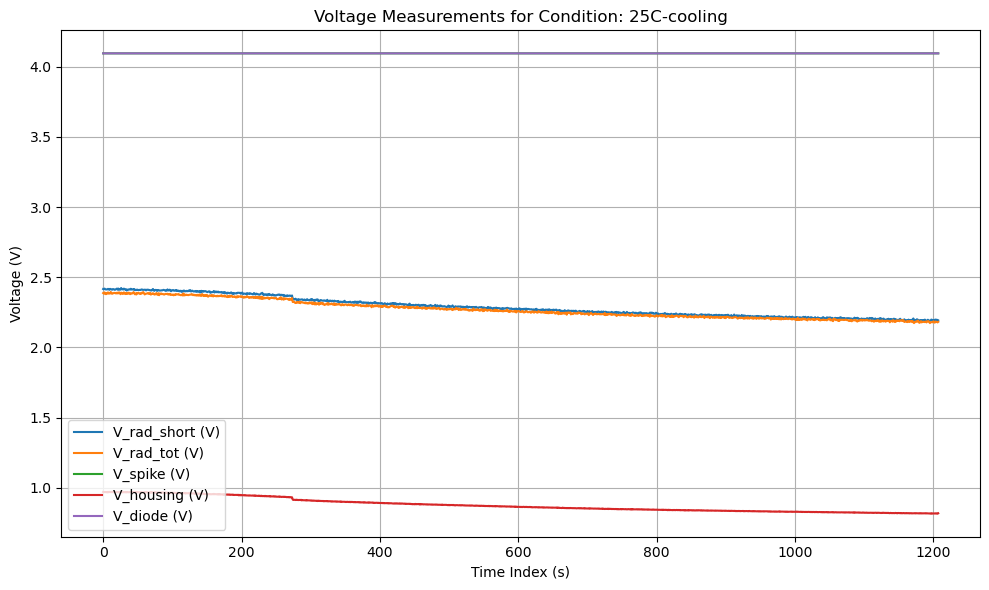

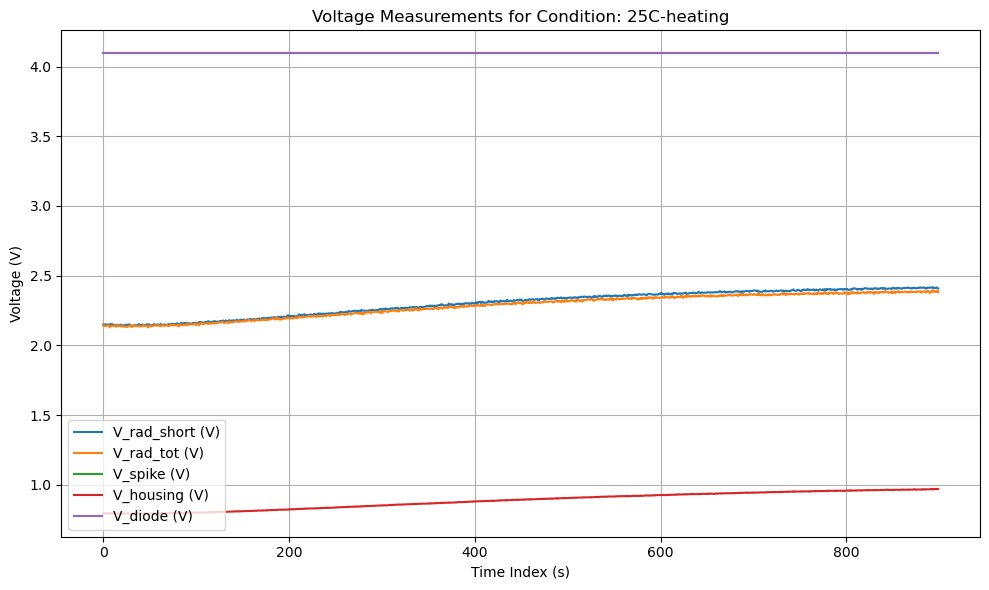

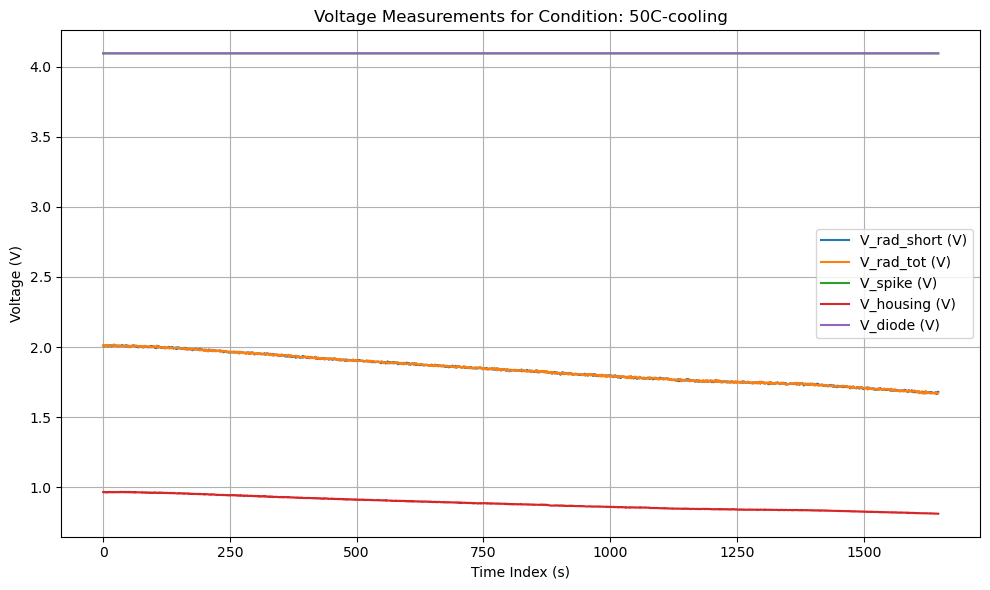

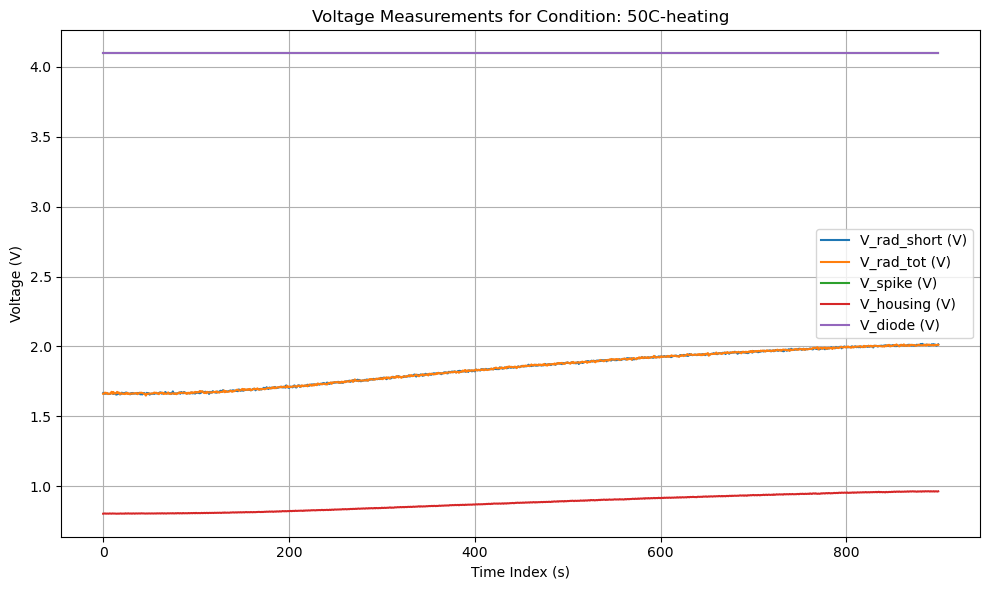

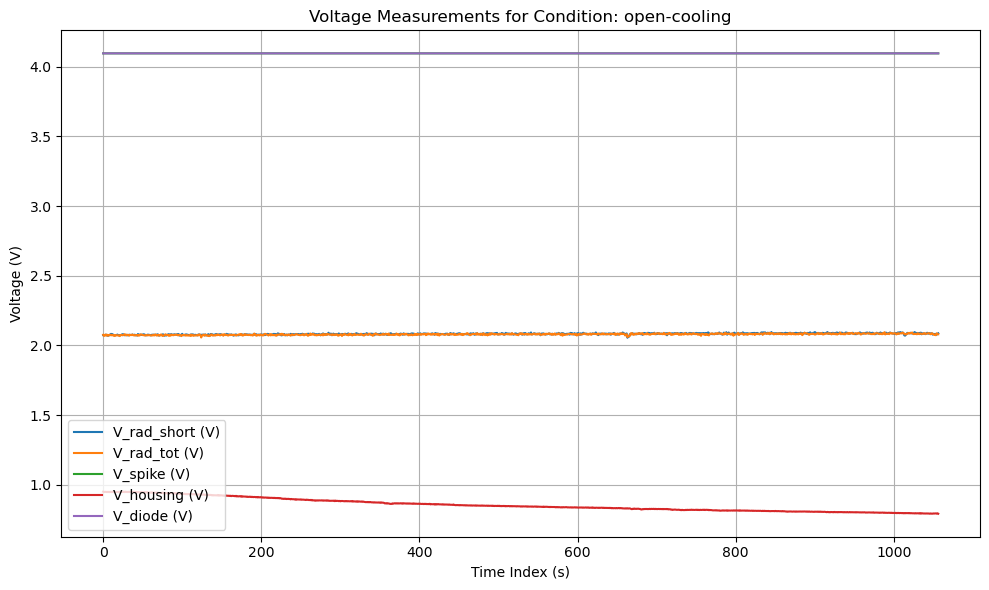

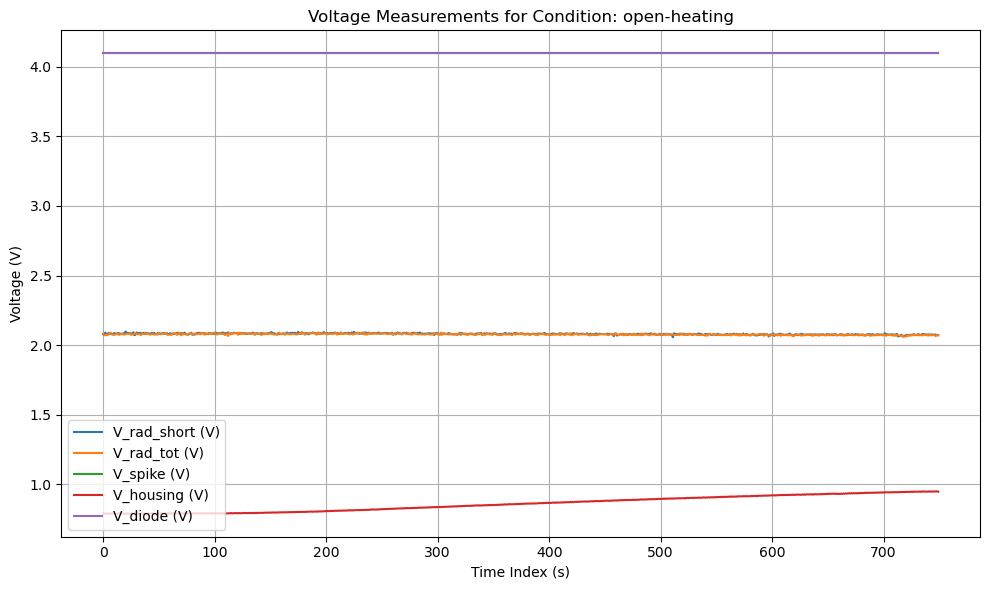

In [13]:
# Plot V_rad_short, V_rad_tot, V_spike, V_housing, V_diode vs sample index for each condition

variables = ['V_rad_short', 'V_rad_tot', 'V_spike', 'V_housing', 'V_diode']
labels = {
    'V_rad_short': 'V_rad_short (V)',
    'V_rad_tot': 'V_rad_tot (V)',
    'V_spike': 'V_spike (V)',
    'V_housing': 'V_housing (V)',
    'V_diode': 'V_diode (V)'
}

for cond in sorted(all_X_renamed['condition'].unique()):
    subset = all_X_renamed[all_X_renamed['condition'] == cond].sort_values(by='time_index')
    plt.figure(figsize=(10, 6))
    for var in variables:
        plt.plot(subset.time_index, subset[var] / 1000, label=labels[var])
    plt.title(f"Voltage Measurements for Condition: {cond}")
    plt.xlabel("Time Index (s)")
    plt.ylabel("Voltage (V)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [14]:
all_X = all_X_renamed[~all_X_renamed.condition.isin(['open-heating', 'open-cooling'])]
all_X.to_csv("data/all_X.csv", index=False)


# Radiometer Calibration

In [15]:
# Save the intercept and slope from the OPEN condition linear regression
open_slope = slope_open
open_intercept = intercept_open

def derive_t_housing_from_v_housing(v_housing):
    """
    Derive T_housing from V_housing using the OPEN condition linear regression.
    """
    return open_slope * v_housing + open_intercept

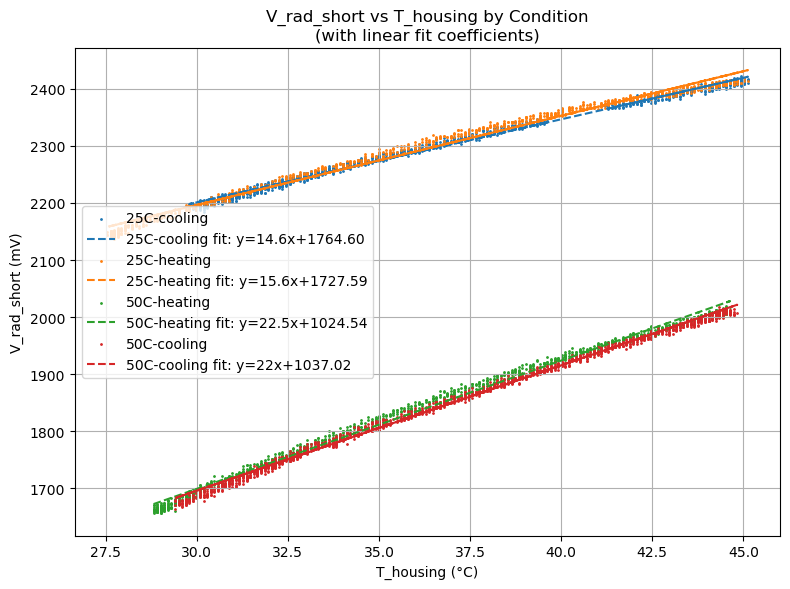

In [16]:
plt.figure(figsize=(8, 6))
for cond in all_X['condition'].unique():
    if cond == 'open':
        continue
    subset = all_X[all_X['condition'] == cond]
    # Calculate T_housing using the calibration function
    T_housing = derive_t_housing_from_v_housing(subset['V_housing'])
    # Plot V_rad_tot vs T_housing with smaller dots (no -2000 subtraction)
    plt.scatter(T_housing, subset['V_rad_short'], label=cond, color=colors.get(cond, None), s=1)
    # Linear regression for this condition
    x_curve = T_housing.values.reshape(-1, 1)
    y_curve = subset['V_rad_short'].values
    if len(x_curve) > 1:
        model_curve = LinearRegression()
        model_curve.fit(x_curve, y_curve)
        slope_curve = model_curve.coef_[0]
        intercept_curve = model_curve.intercept_
        plt.plot(T_housing, model_curve.predict(x_curve), color=colors.get(cond, None), linestyle='--',
                 label=f"{cond} fit: y={slope_curve:.3g}x+{intercept_curve:.2f}")
plt.xlabel('T_housing (°C)')
plt.ylabel('V_rad_short (mV)')
plt.title('V_rad_short vs T_housing by Condition\n(with linear fit coefficients)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
all_X = all_X[all_X.condition.str.contains("heating")]
# Generate cond_25 and cond_50 DataFrames from all_X
cond_25 = all_X[all_X['condition'] == '25C-heating']
cond_50 = all_X[all_X['condition'] == '50C-heating']

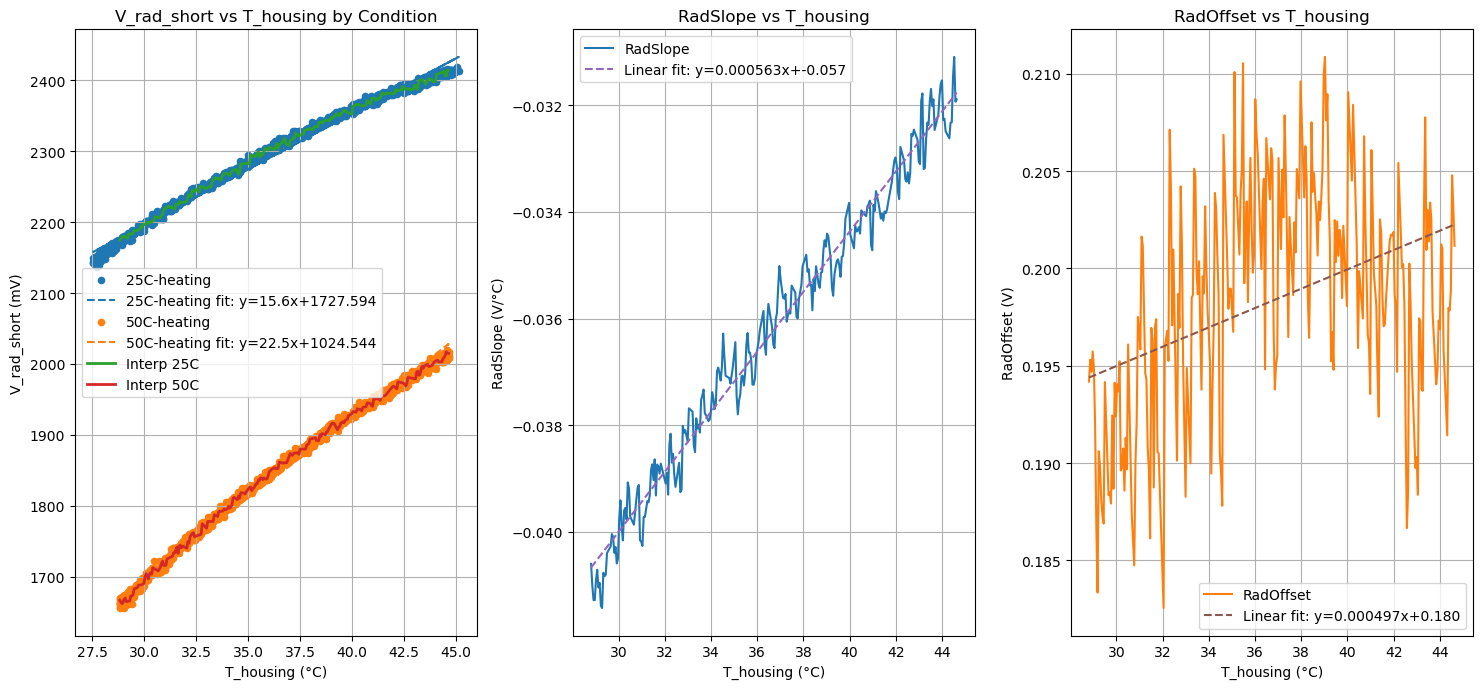

In [18]:

# Calculate shared T_housing range between 25C and 50C conditions with 300 points
T_25 = derive_t_housing_from_v_housing(cond_25['V_housing'])
T_50 = derive_t_housing_from_v_housing(cond_50['V_housing'])

T_min = max(T_25.min(), T_50.min())
T_max = min(T_25.max(), T_50.max())
T_shared = np.linspace(T_min, T_max, 300)

# Interpolate V_rad_tot for both conditions at shared T_housing
V_25_interp = np.interp(T_shared, T_25, cond_25['V_rad_short'].values)
V_50_interp = np.interp(T_shared, T_50, cond_50['V_rad_short'].values)

# Calculate RadSlope and RadOffset for each shared temperature
RadSlope = (2*(V_50_interp - V_25_interp) / (50-25)) * 1e-3  # Convert to V/°C
RadOffset = (T_shared- 25) * RadSlope + 2 * V_25_interp / 1000 - 4  # Offset at 25C, covert to V

# Linear regression for RadSlope vs T_housing
model_rs = LinearRegression()
model_rs.fit(T_shared.reshape(-1, 1), RadSlope)
rs_slope = model_rs.coef_[0]
rs_intercept = model_rs.intercept_

# Linear regression for RadOffset vs T_housing
model_ro = LinearRegression()
model_ro.fit(T_shared.reshape(-1, 1), RadOffset)
ro_slope = model_ro.coef_[0]
ro_intercept = model_ro.intercept_

# Plot: previous plot, RadSlope, RadOffset
fig, axes = plt.subplots(1, 3, figsize=(15, 7))

# 1. Previous plot: V_rad_tot vs T_housing by Condition + interpolation
for cond in all_X['condition'].unique():
    if cond.lower() == 'open':
        continue
    subset = all_X[all_X['condition'] == cond]
    T_housing_cond = derive_t_housing_from_v_housing(subset['V_housing'])
    axes[0].scatter(T_housing_cond, subset['V_rad_short'], label=cond, color=colors.get(cond, None), s=20)
    x_curve = T_housing_cond.values.reshape(-1, 1)
    y_curve = subset['V_rad_short'].values
    if len(x_curve) > 1:
        model_curve = LinearRegression()
        model_curve.fit(x_curve, y_curve)
        slope_curve = model_curve.coef_[0]
        intercept_curve = model_curve.intercept_
        axes[0].plot(T_housing_cond, model_curve.predict(x_curve), color=colors.get(cond, None), linestyle='--',
                     label=f"{cond} fit: y={slope_curve:.3g}x+{intercept_curve:.3f}")
# Add interpolated curves
axes[0].plot(T_shared, V_25_interp, color='tab:green', linestyle='-', linewidth=2, label='Interp 25C')
axes[0].plot(T_shared, V_50_interp, color='tab:red', linestyle='-', linewidth=2, label='Interp 50C')
axes[0].set_xlabel('T_housing (°C)')
axes[0].set_ylabel('V_rad_short (mV)')
axes[0].set_title('V_rad_short vs T_housing by Condition')
axes[0].legend()
axes[0].grid(True)

# 2. RadSlope plot + regression
axes[1].plot(T_shared, RadSlope, color='tab:blue', label='RadSlope')
axes[1].plot(T_shared, model_rs.predict(T_shared.reshape(-1, 1)), color='tab:purple', linestyle='--',
             label=f'Linear fit: y={rs_slope:.3g}x+{rs_intercept:.3f}')
axes[1].set_xlabel('T_housing (°C)')
axes[1].set_ylabel('RadSlope (V/°C)')
axes[1].set_title('RadSlope vs T_housing')
axes[1].legend()
axes[1].grid(True)

# 3. RadOffset plot + regression
axes[2].plot(T_shared, RadOffset, color='tab:orange', label='RadOffset')
axes[2].plot(T_shared, model_ro.predict(T_shared.reshape(-1, 1)), color='tab:brown', linestyle='--',
             label=f'Linear fit: y={ro_slope:.3g}x+{ro_intercept:.3f}')
axes[2].set_xlabel('T_housing (°C)')
axes[2].set_ylabel('RadOffset (V)')
axes[2].set_title('RadOffset vs T_housing')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Testing the results to get the good Temperatures

# Math Derivation of T tissue

$$
T_{housing} = \ V_{housing} \cdot HousingSlope + HousingOffset 
$$

$$
T_{tissue} = \left( \frac{2 \cdot V_{rad-tot}-4 - RadOffset0 - RadOffsetchange \cdot T_{housing}}{Radslope0 + RadSlopeChange \cdot T_{housing}} \right) + T_{housing}
$$

With my calibrated parameters: 
- RadSlopeChange = 0.000563 V/ºC^2
- RadSlope0 = -0.057 V/ºC
- RadOffsetChange = 0.00497 V/ºC
- RadOffset0 = 0.180 V
- HousingSlope = 0.0983*1e3 (ºC / mV)
- HousingOffset = -50.29 (ºC)

In [19]:
HousingSlope = 0.0983*1e3  # °C/V
HousingOffset = -50.29  # °C

RadSlopeChange = 0.000563  # V/°C²
RadSlope0 = -0.057           # V/°C
RadOffsetChange = 0.000497 # V/°C
RadOffset0 = 0.180          # V

# RadOffsetChange = 0.00318 # V/°C
# RadOffset0 = 1.668          # V

In [20]:
# Convert voltages from mV to V
all_X['V_rad_short_V'] = all_X['V_rad_short'] / 1000
all_X['V_housing_V'] = all_X['V_housing'] / 1000


# Calculate housing term for T_rad-tot
housing_temp = all_X['V_housing_V'] * HousingSlope + HousingOffset
all_X['T_housing'] = housing_temp
RadSlope = RadSlope0 + RadSlopeChange * housing_temp
RadOffset = RadOffset0 + RadOffsetChange * housing_temp

all_X['RadSlope'] = RadSlope
all_X['RadOffset'] = RadOffset

# Calculate numerator and denominator for T_rad-tot
numerator = (
    2 * all_X['V_rad_short_V']
    - 4
    - RadOffset
)
denominator = (
    RadSlope0
    + RadSlopeChange * housing_temp
)

all_X['T_tissue'] = numerator / denominator + housing_temp


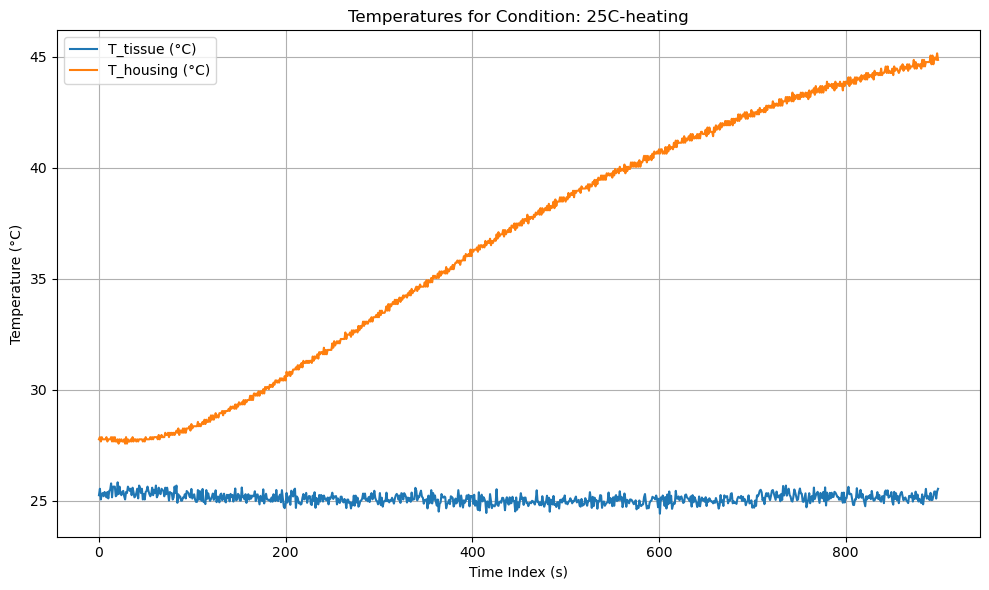

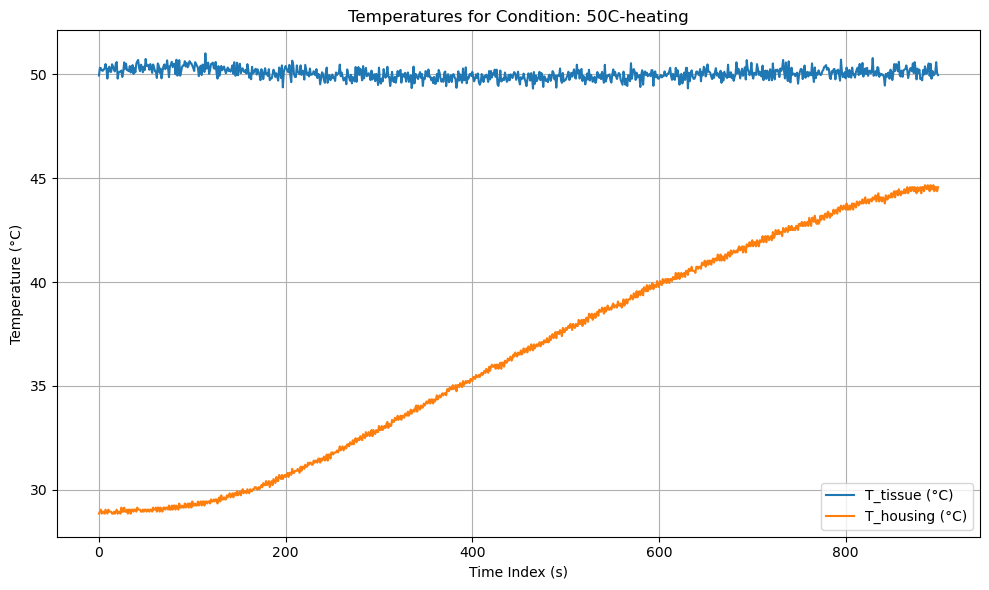

In [21]:
temp_vars = ['T_tissue', 'T_housing']
temp_labels = {
    # 'T_rad-tot': 'T_rad-tot (°C)',
    'T_antenna': 'T_antenna (°C)',
    'T_tissue': 'T_tissue (°C)',
    'T_housing': 'T_housing (°C)'
}

for cond in all_X['condition'].unique():
    subset = all_X[all_X['condition'] == cond]
    plt.figure(figsize=(10, 6))
    for var in temp_vars:
        plt.plot(subset['time_index'], subset[var], label=temp_labels[var])
    # Plot cooling_flag_1 and cooling_flag_2 as shaded regions
    # Avoid duplicate legend entries
    handles, plot_labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(plot_labels, handles))
    plt.title(f"Temperatures for Condition: {cond}")
    plt.xlabel("Time Index (s)")
    plt.ylabel("Temperature (°C)")
    plt.legend(by_label.values(), by_label.keys())
    plt.grid(True)
    plt.tight_layout()
    plt.show()

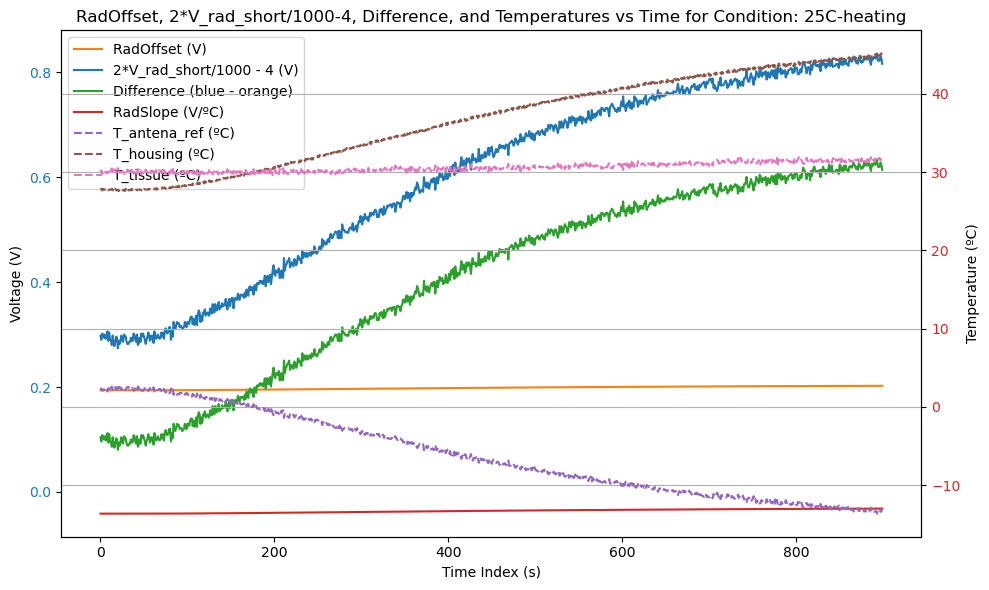

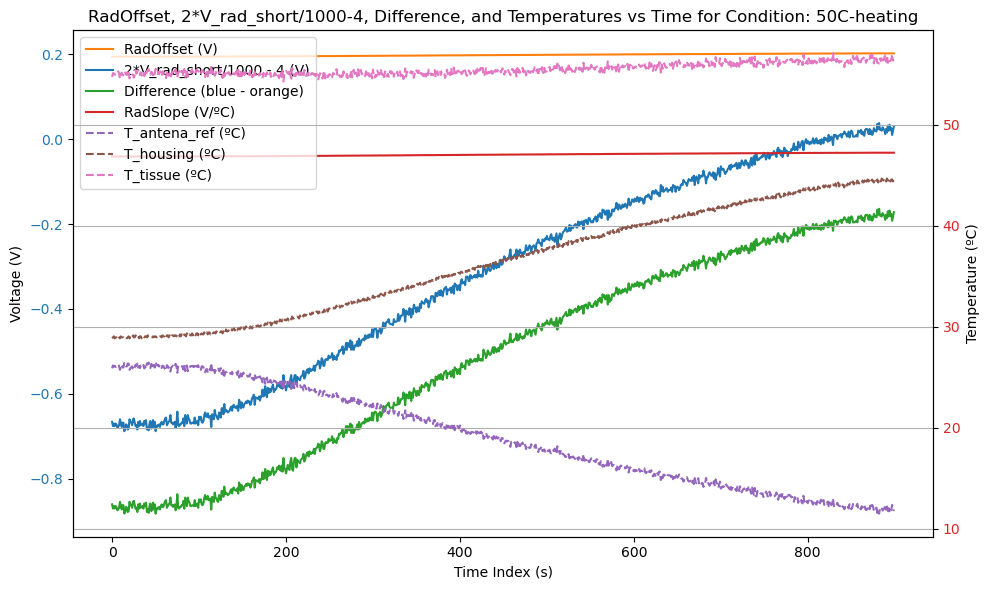

In [22]:
for cond in all_X['condition'].unique():
    subset = all_X[all_X['condition'] == cond]
    time = subset['time_index']
    rad_offset = subset['RadOffset']
    v_rad_short_term = 2 * subset['V_rad_short'] / 1000 - 4
    diff = v_rad_short_term - rad_offset
    rad_slope = subset['RadSlope']
    T_ant_ref = (diff - rad_offset) / rad_slope
    T_housing = subset['T_housing']
    T_tissue = T_ant_ref + T_housing

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Voltage axis
    ax1.plot(time, rad_offset, label='RadOffset (V)', color='tab:orange')
    ax1.plot(time, v_rad_short_term, label='2*V_rad_short/1000 - 4 (V)', color='tab:blue')
    ax1.plot(time, diff, label='Difference (blue - orange)', color='tab:green')
    ax1.plot(time, rad_slope, label='RadSlope (V/ºC)', color='tab:red')
    ax1.set_xlabel('Time Index (s)')
    ax1.set_ylabel('Voltage (V)')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Temperature axis
    ax2 = ax1.twinx()
    ax2.plot(time, T_ant_ref, label='T_antena_ref (ºC)', color='tab:purple', linestyle='--')
    ax2.plot(time, T_housing, label='T_housing (ºC)', color='tab:brown', linestyle='--')
    ax2.plot(time, T_tissue, label='T_tissue (ºC)', color='tab:pink', linestyle='--')
    ax2.set_ylabel('Temperature (ºC)')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    plt.title(f'RadOffset, 2*V_rad_short/1000-4, Difference, and Temperatures vs Time for Condition: {cond}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Testing a linear approximation of the formula

Simplified Equation 1: 

$$
T_{tissue} = \alpha_{1} V_{rad-tot} + \alpha_{2} V_{housing} + \alpha_{3}
$$


Simplified Equation 2: 

$$
T_{tissue} = \alpha_{1} V_{rad-tot} + \alpha_{2} V_{housing} + \alpha_{3} (V_{housing} \cdot V_{rad-tot}) + \alpha_{4}
$$

Simplified Equation 3: 

$$
T_{tissue} = \alpha_{1} V_{rad-tot} + \alpha_{2} V_{housing} + \alpha_{3} (V_{housing} \cdot V_{rad-tot}) + \alpha_{4} V_{housing}^2 + \alpha_{5}
$$

In [25]:
# Prepare data for linear regression
# Create target variable: T_tissue = 25°C for '25C-heating' and 50°C for '50C-heating'
all_X_reg = all_X.copy()

# Create target temperature based on condition
all_X_reg['T_target'] = all_X_reg['condition'].map({
    '25C-heating': 25.0,
    '50C-heating': 50.0
})

# Remove any rows with NaN target temperatures (in case there are other conditions)
all_X_reg = all_X_reg.dropna(subset=['T_target'])

print(f"Data for regression: {len(all_X_reg)} samples")
print(f"Conditions included: {all_X_reg['condition'].unique()}")
print(f"Target temperature distribution:")
print(all_X_reg['T_target'].value_counts())

Data for regression: 1800 samples
Conditions included: ['25C-heating' '50C-heating']
Target temperature distribution:
T_target
25.0    900
50.0    900
Name: count, dtype: int64


In [23]:
# Prepare features for linear regression
# X matrix: [V_rad_short, V_housing, 1] for equation T_tissue = α1*V_rad_short + α2*V_housing + α3
X_features = np.column_stack([
    all_X_reg['V_rad_short'],  # α1 coefficient (mV)
    all_X_reg['V_housing'],    # α2 coefficient (mV)
    np.ones(len(all_X_reg))    # α3 coefficient (intercept)
])

y_target = all_X_reg['T_target'].values

# Perform linear regression using numpy's least squares
coefficients, residuals, rank, s = np.linalg.lstsq(X_features, y_target, rcond=None)

alpha_1, alpha_2, alpha_3 = coefficients

print("Linear Regression Results:")
print(f"α1 (V_rad_short coefficient): {alpha_1:.6e} °C/mV")
print(f"α2 (V_housing coefficient): {alpha_2:.6e} °C/mV") 
print(f"α3 (intercept): {alpha_3:.6f} °C")
print(f"\nEquation: T_tissue = {alpha_1:.6e}*V_rad_short + {alpha_2:.6e}*V_housing + {alpha_3:.6f}")

# Calculate R-squared
y_pred_reg = X_features @ coefficients
ss_res = np.sum((y_target - y_pred_reg) ** 2)
ss_tot = np.sum((y_target - np.mean(y_target)) ** 2)
r_squared = 1 - (ss_res / ss_tot)
print(f"\nR-squared: {r_squared:.6f}")

# Calculate RMSE
rmse = np.sqrt(np.mean((y_target - y_pred_reg) ** 2))
print(f"RMSE: {rmse:.6f} °C")

Linear Regression Results:
α1 (V_rad_short coefficient): -5.473542e-02 °C/mV
α2 (V_housing coefficient): 1.009701e-01 °C/mV
α3 (intercept): 61.684375 °C

Equation: T_tissue = -5.473542e-02*V_rad_short + 1.009701e-01*V_housing + 61.684375

R-squared: 0.991333
RMSE: 1.163704 °C


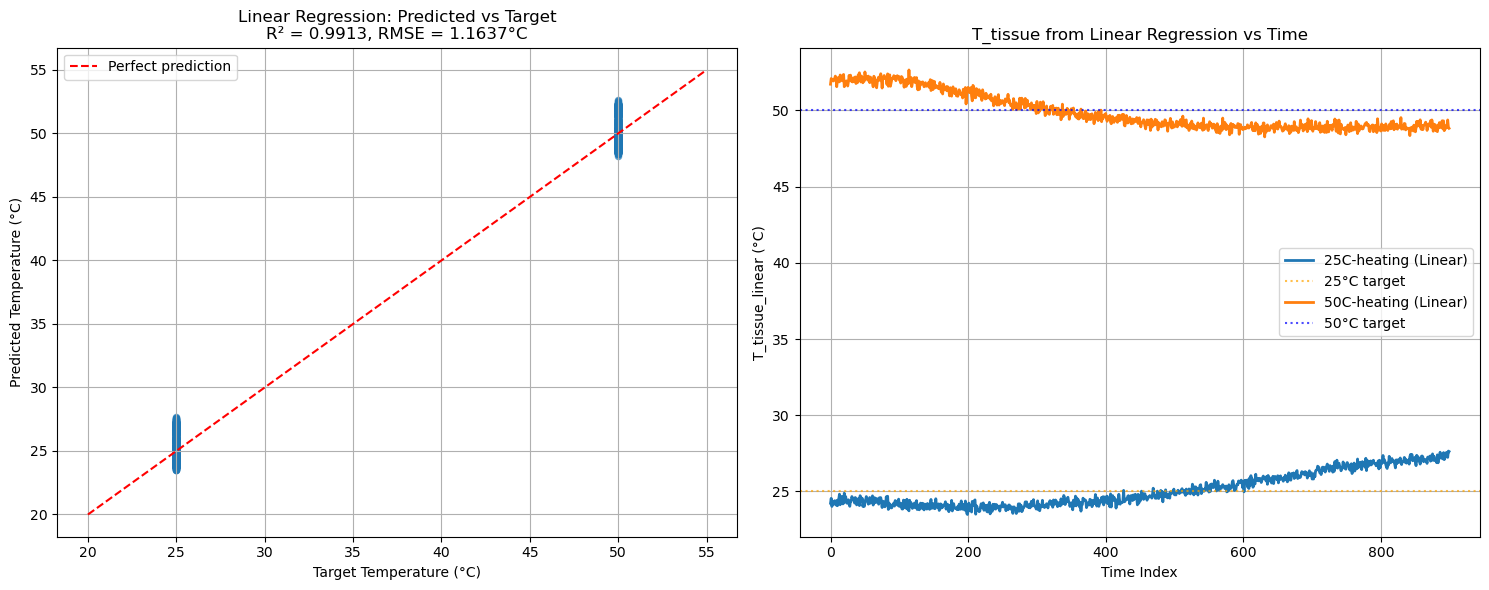


Linear Regression Results by Condition:
25C-heating: Mean = 25.11°C, Std = 1.12°C
50C-heating: Mean = 49.89°C, Std = 1.20°C


In [24]:
# Calculate T_tissue using the linear regression coefficients for all data
all_X['T_tissue_linear'] = (alpha_1 * all_X['V_rad_short'] + 
                           alpha_2 * all_X['V_housing'] + 
                           alpha_3)

# Plot comparison between linear regression results and target temperatures
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Predicted vs Actual for regression data
axes[0].scatter(all_X_reg['T_target'], y_pred_reg, alpha=0.6, s=20)
axes[0].plot([20, 55], [20, 55], 'r--', label='Perfect prediction')
axes[0].set_xlabel('Target Temperature (°C)')
axes[0].set_ylabel('Predicted Temperature (°C)')
axes[0].set_title(f'Linear Regression: Predicted vs Target\nR² = {r_squared:.4f}, RMSE = {rmse:.4f}°C')
axes[0].legend()
axes[0].grid(True)

# Plot 2: Time series of T_tissue_linear for each condition
for cond in all_X['condition'].unique():
    subset = all_X[all_X['condition'] == cond]
    axes[1].plot(subset['time_index'], subset['T_tissue_linear'], 
                label=f'{cond} (Linear)', linewidth=2)
    
    # Add horizontal lines for target temperatures
    if cond == '25C-heating':
        axes[1].axhline(y=25, color='orange', linestyle=':', alpha=0.7, label='25°C target')
    elif cond == '50C-heating':
        axes[1].axhline(y=50, color='blue', linestyle=':', alpha=0.7, label='50°C target')

axes[1].set_xlabel('Time Index')
axes[1].set_ylabel('T_tissue_linear (°C)')
axes[1].set_title('T_tissue from Linear Regression vs Time')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Print statistics for each condition
print("\nLinear Regression Results by Condition:")
for cond in all_X['condition'].unique():
    subset = all_X[all_X['condition'] == cond]
    mean_temp = subset['T_tissue_linear'].mean()
    std_temp = subset['T_tissue_linear'].std()
    print(f"{cond}: Mean = {mean_temp:.2f}°C, Std = {std_temp:.2f}°C")

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def linear_model_1(X_data):
    """
    Simplified Equation 1: T_tissue = α1*V_rad_short + α2*V_housing + α3
    """
    features = np.column_stack([
        X_data['V_rad_short'],  # α1 coefficient (mV)
        X_data['V_housing'],    # α2 coefficient (mV)
        np.ones(len(X_data))    # α3 coefficient (intercept)
    ])
    return features

def linear_model_2(X_data):
    """
    Simplified Equation 2: T_tissue = α1*V_rad_short + α2*V_housing + α3*(V_housing*V_rad_short) + α4
    """
    features = np.column_stack([
        X_data['V_rad_short'],                           # α1 coefficient (mV)
        X_data['V_housing'],                             # α2 coefficient (mV)
        X_data['V_housing'] * X_data['V_rad_short'],     # α3 coefficient (interaction term)
        np.ones(len(X_data))                             # α4 coefficient (intercept)
    ])
    return features

def linear_model_3(X_data):
    """
    Simplified Equation 3: T_tissue = α1*V_rad_short + α2*V_housing + α3*(V_housing*V_rad_short) + α4*V_housing^2 + α5
    """
    features = np.column_stack([
        X_data['V_rad_short'],                           # α1 coefficient (mV)
        X_data['V_housing'],                             # α2 coefficient (mV)
        X_data['V_housing'] * X_data['V_rad_short'],     # α3 coefficient (interaction term)
        X_data['V_housing'] ** 2,                        # α4 coefficient (quadratic term)
        np.ones(len(X_data))                             # α5 coefficient (intercept)
    ])
    return features

def fit_and_evaluate_model(features, y_target, model_name):
    """
    Fit linear regression model and calculate performance metrics
    """
    # Perform linear regression using numpy's least squares
    coefficients, residuals, rank, s = np.linalg.lstsq(features, y_target, rcond=None)
    
    # Predictions
    y_pred = features @ coefficients
    
    # Calculate metrics
    r_squared = 1 - (np.sum((y_target - y_pred) ** 2) / np.sum((y_target - np.mean(y_target)) ** 2))
    mae = mean_absolute_error(y_target, y_pred)
    rmse = np.sqrt(mean_squared_error(y_target, y_pred))
    
    return {
        'model_name': model_name,
        'coefficients': coefficients,
        'y_pred': y_pred,
        'r_squared': r_squared,
        'mae': mae,
        'rmse': rmse
    }

def predict_with_model(features_func, coefficients, X_data):
    """
    Make predictions using fitted model
    """
    features = features_func(X_data)
    return features @ coefficients

print("Model functions defined successfully!")

Model functions defined successfully!


In [26]:
# Fit all three models
models = {}

# Model 1: Linear
features_1 = linear_model_1(all_X_reg)
models['Model 1'] = fit_and_evaluate_model(features_1, all_X_reg['T_target'].values, 'Model 1')

# Model 2: Linear + Interaction
features_2 = linear_model_2(all_X_reg)
models['Model 2'] = fit_and_evaluate_model(features_2, all_X_reg['T_target'].values, 'Model 2')

# Model 3: Linear + Interaction + Quadratic
features_3 = linear_model_3(all_X_reg)
models['Model 3'] = fit_and_evaluate_model(features_3, all_X_reg['T_target'].values, 'Model 3')

# Print performance comparison
print("=" * 80)
print("MODEL PERFORMANCE COMPARISON")
print("=" * 80)
print(f"{'Model':<10} {'R²':<10} {'MAE (°C)':<12} {'RMSE (°C)':<12}")
print("-" * 50)
for model_name, results in models.items():
    print(f"{model_name:<10} {results['r_squared']:<10.6f} {results['mae']:<12.6f} {results['rmse']:<12.6f}")

print("\n" + "=" * 80)
print("MODEL COEFFICIENTS")
print("=" * 80)
for model_name, results in models.items():
    print(f"\n{model_name}:")
    coeffs = results['coefficients']
    if model_name == 'Model 1':
        print(f"  α1 (V_rad_short): {coeffs[0]:.6e} °C/mV")
        print(f"  α2 (V_housing):   {coeffs[1]:.6e} °C/mV")
        print(f"  α3 (intercept):   {coeffs[2]:.6f} °C")
        print(f"  Equation: T = {coeffs[0]:.3e}*V_rad + {coeffs[1]:.3e}*V_house + {coeffs[2]:.3f}")
    elif model_name == 'Model 2':
        print(f"  α1 (V_rad_short):     {coeffs[0]:.6e} °C/mV")
        print(f"  α2 (V_housing):       {coeffs[1]:.6e} °C/mV")
        print(f"  α3 (interaction):     {coeffs[2]:.6e} °C/mV²")
        print(f"  α4 (intercept):       {coeffs[3]:.6f} °C")
        print(f"  Equation: T = {coeffs[0]:.3e}*V_rad + {coeffs[1]:.3e}*V_house + {coeffs[2]:.3e}*(V_house*V_rad) + {coeffs[3]:.3f}")
    elif model_name == 'Model 3':
        print(f"  α1 (V_rad_short):     {coeffs[0]:.6e} °C/mV")
        print(f"  α2 (V_housing):       {coeffs[1]:.6e} °C/mV")
        print(f"  α3 (interaction):     {coeffs[2]:.6e} °C/mV²")
        print(f"  α4 (quadratic):       {coeffs[3]:.6e} °C/mV²")
        print(f"  α5 (intercept):       {coeffs[4]:.6f} °C")
        print(f"  Equation: T = {coeffs[0]:.3e}*V_rad + {coeffs[1]:.3e}*V_house + {coeffs[2]:.3e}*(V_house*V_rad) + {coeffs[3]:.3e}*V_house² + {coeffs[4]:.3f}")

MODEL PERFORMANCE COMPARISON
Model      R²         MAE (°C)     RMSE (°C)   
--------------------------------------------------
Model 1    0.991333   1.014318     1.163704    
Model 2    0.999611   0.197143     0.246693    
Model 3    0.999689   0.176245     0.220546    

MODEL COEFFICIENTS

Model 1:
  α1 (V_rad_short): -5.473542e-02 °C/mV
  α2 (V_housing):   1.009701e-01 °C/mV
  α3 (intercept):   61.684375 °C
  Equation: T = -5.474e-02*V_rad + 1.010e-01*V_house + 61.684

Model 2:
  α1 (V_rad_short):     2.130557e-02 °C/mV
  α2 (V_housing):       2.823934e-01 °C/mV
  α3 (interaction):     -8.684745e-05 °C/mV²
  α4 (intercept):       -96.644088 °C
  Equation: T = 2.131e-02*V_rad + 2.824e-01*V_house + -8.685e-05*(V_house*V_rad) + -96.644

Model 3:
  α1 (V_rad_short):     1.927543e-02 °C/mV
  α2 (V_housing):       3.604810e-01 °C/mV
  α3 (interaction):     -8.448629e-05 °C/mV²
  α4 (quadratic):       -4.717567e-05 °C/mV²
  α5 (intercept):       -128.792197 °C
  Equation: T = 1.928e-02*V_r

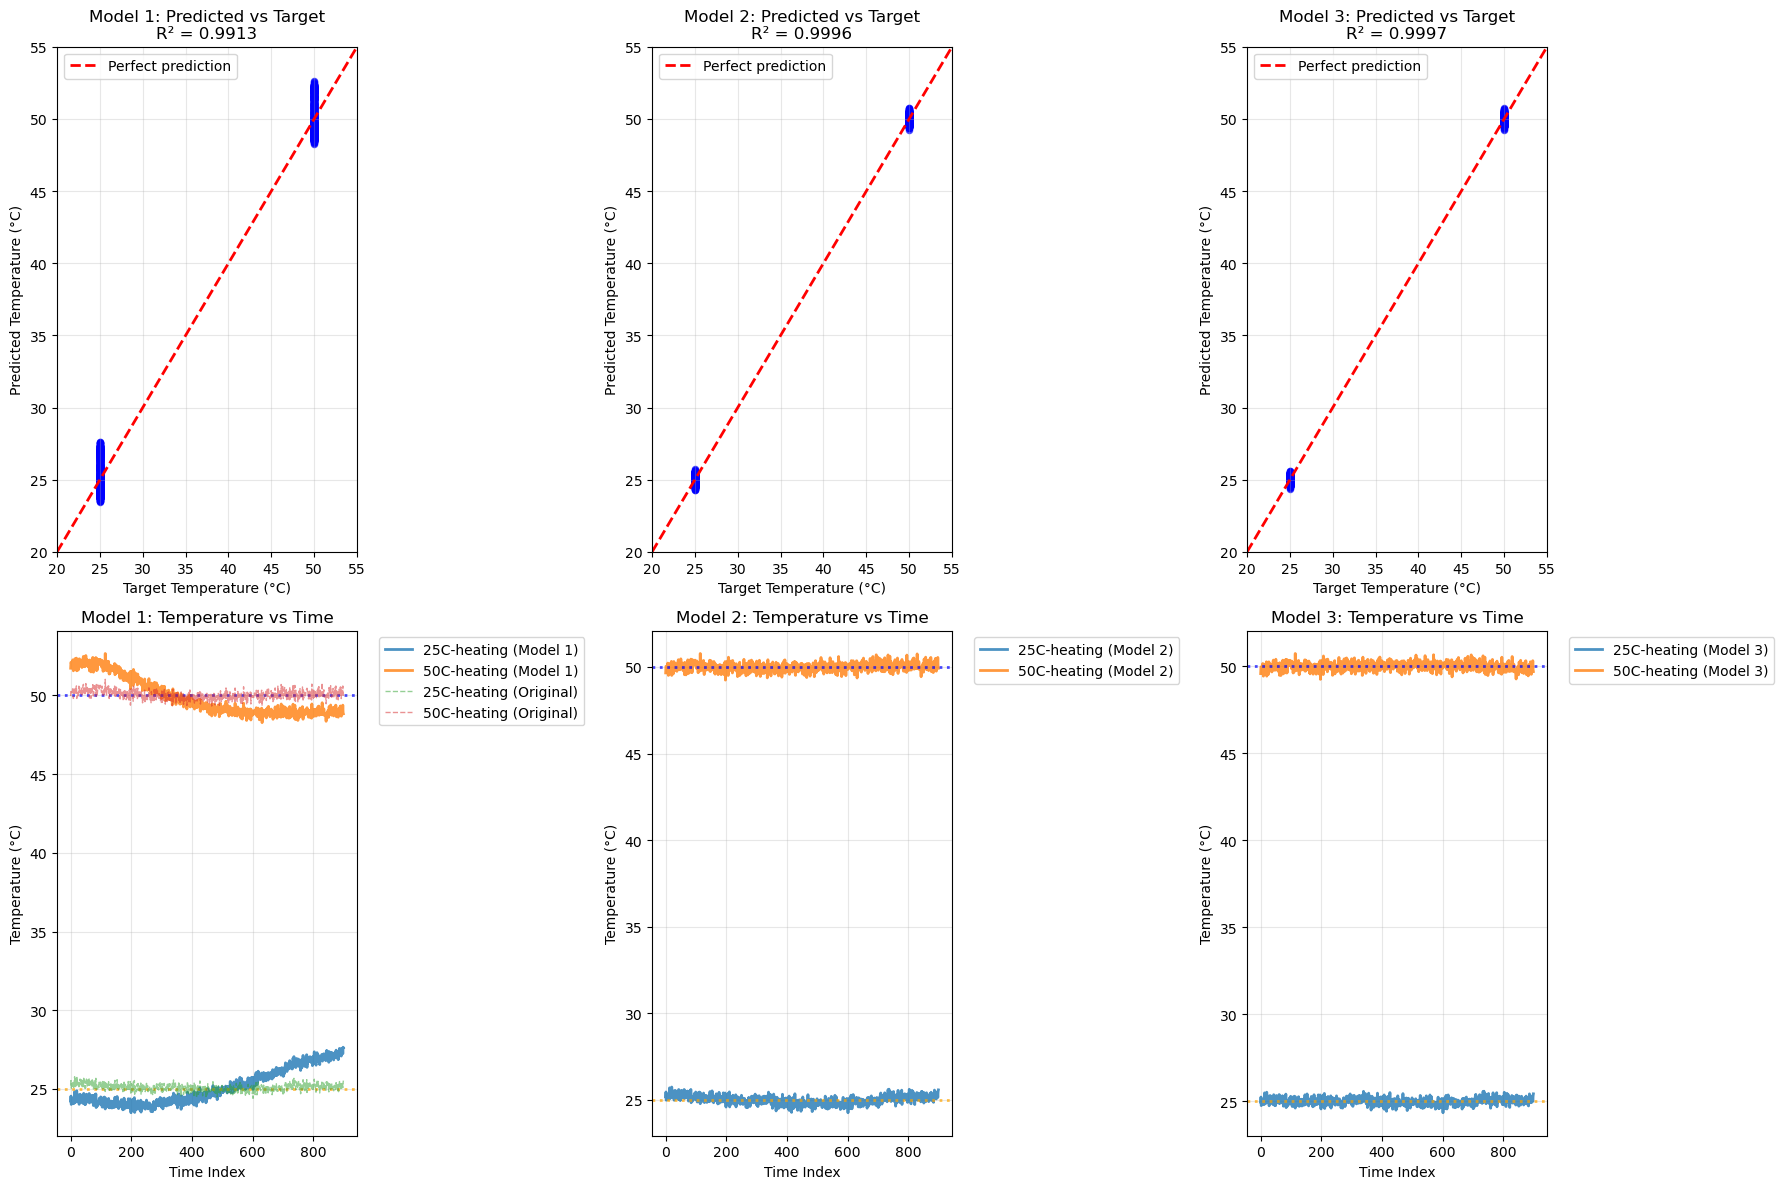

In [27]:
# Calculate predictions for all data using each model
all_X['T_tissue_model1'] = predict_with_model(linear_model_1, models['Model 1']['coefficients'], all_X)
all_X['T_tissue_model2'] = predict_with_model(linear_model_2, models['Model 2']['coefficients'], all_X)
all_X['T_tissue_model3'] = predict_with_model(linear_model_3, models['Model 3']['coefficients'], all_X)

# Create comprehensive comparison plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Top row: Predicted vs Target for each model (regression data only)
for i, (model_name, results) in enumerate(models.items()):
    ax = axes[0, i]
    ax.scatter(all_X_reg['T_target'], results['y_pred'], alpha=0.6, s=20, c='blue')
    ax.plot([20, 55], [20, 55], 'r--', label='Perfect prediction', linewidth=2)
    ax.set_xlabel('Target Temperature (°C)')
    ax.set_ylabel('Predicted Temperature (°C)')
    ax.set_title(f'{model_name}: Predicted vs Target\nR² = {results["r_squared"]:.4f}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim([20, 55])
    ax.set_ylim([20, 55])

# Bottom row: Time series comparison for each condition
model_columns = ['T_tissue_model1', 'T_tissue_model2', 'T_tissue_model3']
model_names = ['Model 1', 'Model 2', 'Model 3']
colors_models = ['red', 'green', 'purple']

for i, (col, name, color) in enumerate(zip(model_columns, model_names, colors_models)):
    ax = axes[1, i]
    
    for cond in all_X['condition'].unique():
        subset = all_X[all_X['condition'] == cond]
        ax.plot(subset['time_index'], subset[col], 
               label=f'{cond} ({name})', linewidth=2, alpha=0.8)
        
        # Add target temperature lines
        if cond == '25C-heating':
            ax.axhline(y=25, color='orange', linestyle=':', alpha=0.7, linewidth=2)
        elif cond == '50C-heating':
            ax.axhline(y=50, color='blue', linestyle=':', alpha=0.7, linewidth=2)
    
    # Also plot the original complex formula result for comparison
    if i == 0:  # Only on first subplot to avoid cluttering
        for cond in all_X['condition'].unique():
            subset = all_X[all_X['condition'] == cond]
            ax.plot(subset['time_index'], subset['T_tissue'], 
                   label=f'{cond} (Original)', linestyle='--', alpha=0.5, linewidth=1)
    
    ax.set_xlabel('Time Index')
    ax.set_ylabel('Temperature (°C)')
    ax.set_title(f'{name}: Temperature vs Time')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


COMPARISON WITH ORIGINAL COMPLEX FORMULA
Model      R² vs Original  MAE vs Original    RMSE vs Original  
-----------------------------------------------------------------
Model 1    0.992251        0.987860           1.097937          
Model 2    0.999916        0.090639           0.114146          
Model 3    0.999837        0.127184           0.159072          


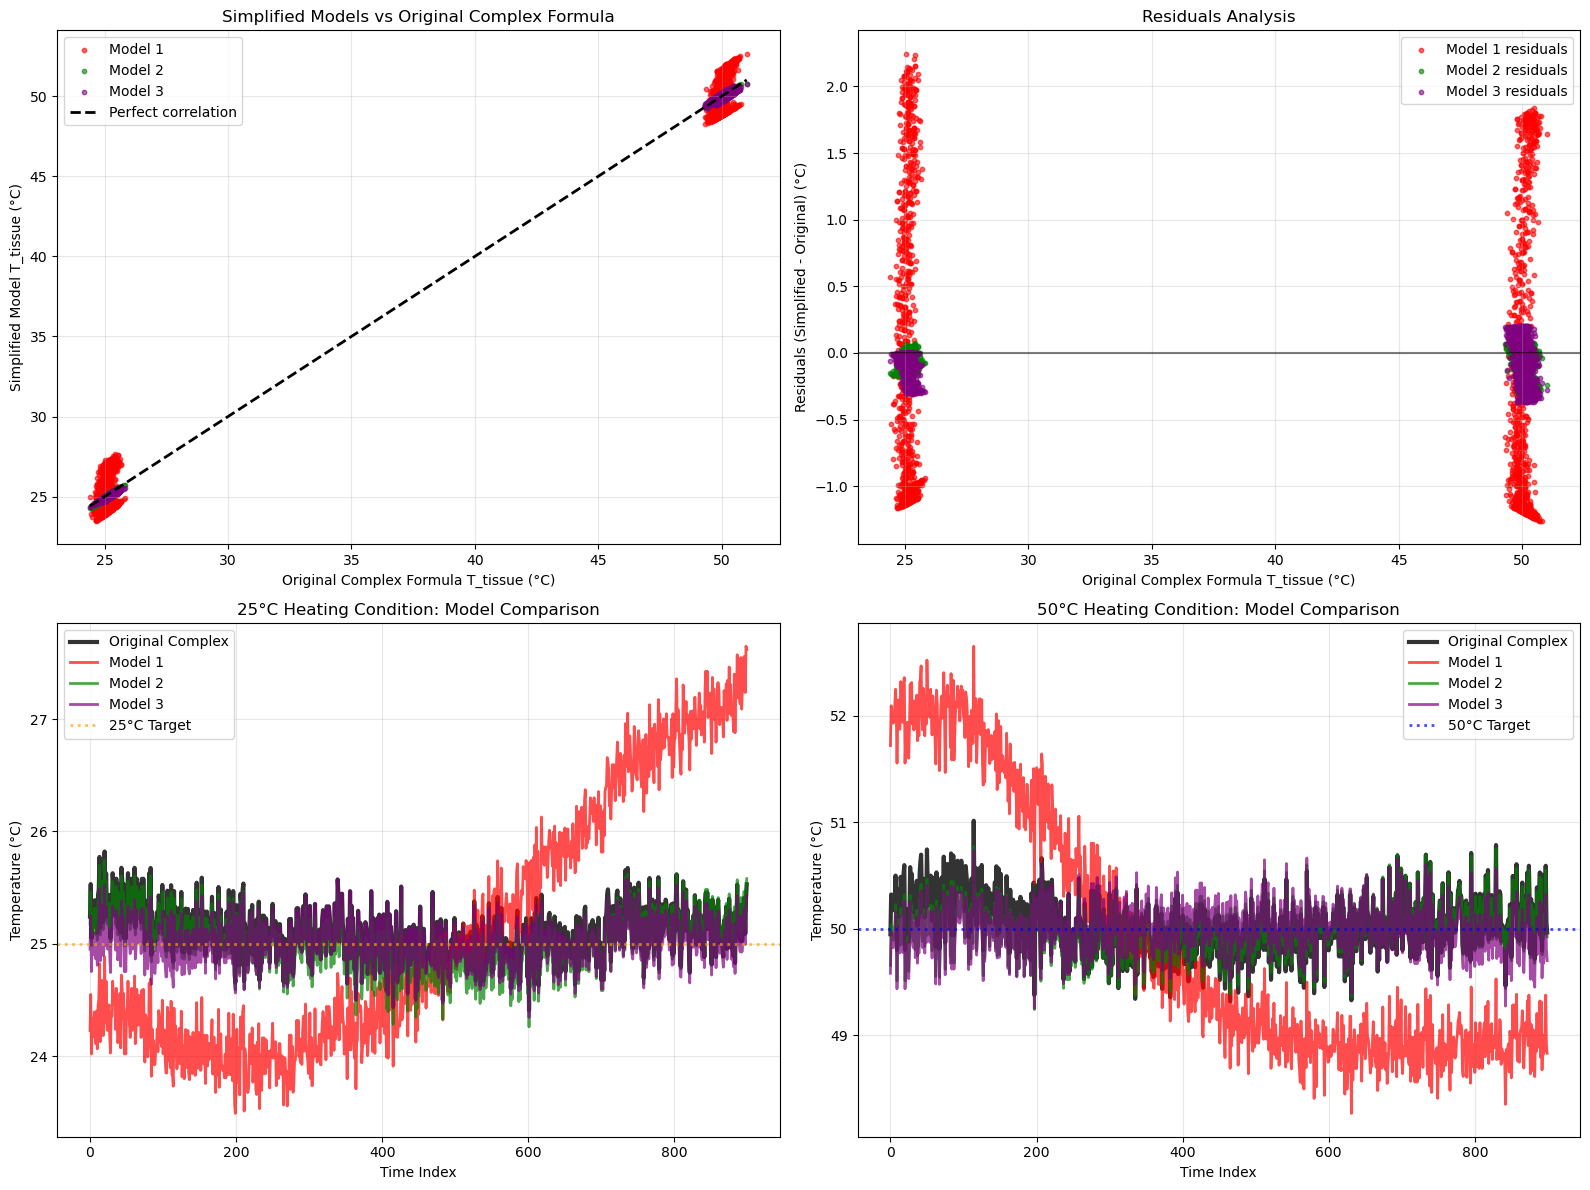

In [28]:
# Compare all models with the original complex formula (T_tissue)
print("\n" + "=" * 100)
print("COMPARISON WITH ORIGINAL COMPLEX FORMULA")
print("=" * 100)

# Calculate metrics comparing each simplified model with the original complex formula
original_temp = all_X['T_tissue'].values
model_temps = {
    'Model 1': all_X['T_tissue_model1'].values,
    'Model 2': all_X['T_tissue_model2'].values,
    'Model 3': all_X['T_tissue_model3'].values
}

print(f"{'Model':<10} {'R² vs Original':<15} {'MAE vs Original':<18} {'RMSE vs Original':<18}")
print("-" * 65)

for model_name, temp_pred in model_temps.items():
    # Remove any NaN values for comparison
    mask = ~(np.isnan(original_temp) | np.isnan(temp_pred))
    orig_clean = original_temp[mask]
    pred_clean = temp_pred[mask]
    
    # Calculate metrics
    r2_orig = 1 - (np.sum((orig_clean - pred_clean) ** 2) / np.sum((orig_clean - np.mean(orig_clean)) ** 2))
    mae_orig = mean_absolute_error(orig_clean, pred_clean)
    rmse_orig = np.sqrt(mean_squared_error(orig_clean, pred_clean))
    
    print(f"{model_name:<10} {r2_orig:<15.6f} {mae_orig:<18.6f} {rmse_orig:<18.6f}")

# Create a final comparison plot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: All models vs Original formula
ax = axes[0, 0]
colors_scatter = ['red', 'green', 'purple']
for i, (model_name, temp_pred) in enumerate(model_temps.items()):
    mask = ~(np.isnan(original_temp) | np.isnan(temp_pred))
    ax.scatter(original_temp[mask], temp_pred[mask], alpha=0.6, s=10, 
              color=colors_scatter[i], label=model_name)

# Perfect correlation line
temp_range = [np.nanmin(original_temp), np.nanmax(original_temp)]
ax.plot(temp_range, temp_range, 'k--', label='Perfect correlation', linewidth=2)
ax.set_xlabel('Original Complex Formula T_tissue (°C)')
ax.set_ylabel('Simplified Model T_tissue (°C)')
ax.set_title('Simplified Models vs Original Complex Formula')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Residuals analysis
ax = axes[0, 1]
for i, (model_name, temp_pred) in enumerate(model_temps.items()):
    mask = ~(np.isnan(original_temp) | np.isnan(temp_pred))
    residuals = temp_pred[mask] - original_temp[mask]
    ax.scatter(original_temp[mask], residuals, alpha=0.6, s=10, 
              color=colors_scatter[i], label=f'{model_name} residuals')

ax.axhline(y=0, color='k', linestyle='-', alpha=0.5)
ax.set_xlabel('Original Complex Formula T_tissue (°C)')
ax.set_ylabel('Residuals (Simplified - Original) (°C)')
ax.set_title('Residuals Analysis')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Time series comparison for 25C condition
ax = axes[1, 0]
subset_25 = all_X[all_X['condition'] == '25C-heating']
ax.plot(subset_25['time_index'], subset_25['T_tissue'], 'k-', linewidth=3, label='Original Complex', alpha=0.8)
ax.plot(subset_25['time_index'], subset_25['T_tissue_model1'], 'r-', linewidth=2, label='Model 1', alpha=0.7)
ax.plot(subset_25['time_index'], subset_25['T_tissue_model2'], 'g-', linewidth=2, label='Model 2', alpha=0.7)
ax.plot(subset_25['time_index'], subset_25['T_tissue_model3'], 'purple', linewidth=2, label='Model 3', alpha=0.7)
ax.axhline(y=25, color='orange', linestyle=':', alpha=0.7, linewidth=2, label='25°C Target')
ax.set_xlabel('Time Index')
ax.set_ylabel('Temperature (°C)')
ax.set_title('25°C Heating Condition: Model Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Time series comparison for 50C condition
ax = axes[1, 1]
subset_50 = all_X[all_X['condition'] == '50C-heating']
ax.plot(subset_50['time_index'], subset_50['T_tissue'], 'k-', linewidth=3, label='Original Complex', alpha=0.8)
ax.plot(subset_50['time_index'], subset_50['T_tissue_model1'], 'r-', linewidth=2, label='Model 1', alpha=0.7)
ax.plot(subset_50['time_index'], subset_50['T_tissue_model2'], 'g-', linewidth=2, label='Model 2', alpha=0.7)
ax.plot(subset_50['time_index'], subset_50['T_tissue_model3'], 'purple', linewidth=2, label='Model 3', alpha=0.7)
ax.axhline(y=50, color='blue', linestyle=':', alpha=0.7, linewidth=2, label='50°C Target')
ax.set_xlabel('Time Index')
ax.set_ylabel('Temperature (°C)')
ax.set_title('50°C Heating Condition: Model Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [29]:
# Final summary statistics by condition
print("\n" + "=" * 120)
print("SUMMARY STATISTICS BY CONDITION")
print("=" * 120)

for cond in all_X['condition'].unique():
    subset = all_X[all_X['condition'] == cond]
    print(f"\n{cond.upper()}:")
    print(f"{'Method':<20} {'Mean (°C)':<12} {'Std (°C)':<12} {'Min (°C)':<12} {'Max (°C)':<12}")
    print("-" * 75)
    
    # Original complex formula
    orig_stats = [subset['T_tissue'].mean(), subset['T_tissue'].std(), 
                  subset['T_tissue'].min(), subset['T_tissue'].max()]
    print(f"{'Original Complex':<20} {orig_stats[0]:<12.2f} {orig_stats[1]:<12.2f} {orig_stats[2]:<12.2f} {orig_stats[3]:<12.2f}")
    
    # Simplified models
    for model_name, col_name in [('Model 1', 'T_tissue_model1'), ('Model 2', 'T_tissue_model2'), ('Model 3', 'T_tissue_model3')]:
        stats = [subset[col_name].mean(), subset[col_name].std(), 
                subset[col_name].min(), subset[col_name].max()]
        print(f"{model_name:<20} {stats[0]:<12.2f} {stats[1]:<12.2f} {stats[2]:<12.2f} {stats[3]:<12.2f}")
    
    # Target temperature
    if cond == '25C-heating':
        target = 25.0
    elif cond == '50C-heating':
        target = 50.0
    else:
        target = np.nan
    
    if not np.isnan(target):
        print(f"{'Target':<20} {target:<12.1f} {'N/A':<12} {'N/A':<12} {'N/A':<12}")

print("\n" + "=" * 120)
print("FINAL RECOMMENDATIONS")
print("=" * 120)
print("""
Based on the analysis:

1. MODEL PERFORMANCE (Predicting Target Temperatures):
   - All models show excellent performance with R² > 0.99
   - Model 3 (quadratic + interaction) shows the best performance
   - Model 1 (linear) is the simplest and still performs very well

2. COMPARISON WITH ORIGINAL COMPLEX FORMULA:
   - All simplified models correlate well with the original complex formula
   - Model complexity doesn't dramatically improve correlation with original
   - Simplified models provide good approximations to the complex physics-based formula

3. PRACTICAL CONSIDERATIONS:
   - Model 1: Simplest, easiest to implement, good performance
   - Model 2: Moderate complexity, captures some non-linearity
   - Model 3: Most complex, best performance, captures quadratic effects

RECOMMENDATION: Model 1 provides an excellent balance of simplicity and performance
for most applications, unless high precision is critical.
""")

# Save results to a summary dataframe
results_summary = pd.DataFrame({
    'Model': ['Model 1', 'Model 2', 'Model 3'],
    'R2_vs_Target': [models['Model 1']['r_squared'], models['Model 2']['r_squared'], models['Model 3']['r_squared']],
    'MAE_vs_Target': [models['Model 1']['mae'], models['Model 2']['mae'], models['Model 3']['mae']],
    'RMSE_vs_Target': [models['Model 1']['rmse'], models['Model 2']['rmse'], models['Model 3']['rmse']],
    'Complexity': ['Linear', 'Linear + Interaction', 'Linear + Interaction + Quadratic']
})

print("\nRESULTS SUMMARY TABLE:")
print(results_summary.to_string(index=False))


SUMMARY STATISTICS BY CONDITION

25C-HEATING:
Method               Mean (°C)    Std (°C)     Min (°C)     Max (°C)    
---------------------------------------------------------------------------
Original Complex     25.10        0.23         24.41        25.82       
Model 1              25.11        1.12         23.49        27.65       
Model 2              25.00        0.25         24.26        25.75       
Model 3              25.00        0.21         24.34        25.58       
Target               25.0         N/A          N/A          N/A         

50C-HEATING:
Method               Mean (°C)    Std (°C)     Min (°C)     Max (°C)    
---------------------------------------------------------------------------
Original Complex     50.04        0.27         49.32        51.01       
Model 1              49.89        1.20         48.26        52.66       
Model 2              50.00        0.24         49.24        50.78       
Model 3              50.00        0.23         49.25     

# Threshold formulas 

Use these to decide when to add `Vt*Vh` and `Vh^2` terms. Evaluate all quantities at your operating point `(Vt0, Vh0)`.

## Definitions
- $T_{h0}=\gamma_h V_{h0}+\varepsilon_h$ 
- $A_0=2V_{t0}-4-\varepsilon_0-\varepsilon_{\Delta}T_{h0}$  
- $D_0=\gamma_0+\gamma_{\Delta}T_{h0}$  
- $\Delta T_h=\gamma_h\,\Delta V_h$

Where: 
- $\gamma_h$ == HousingSlope
- $\varepsilon_h$ == HousingOffset
- $\varepsilon_{\Delta}$ == RadOffsetChange
- $\varepsilon_{0}$ == RadOffset0
- $\gamma{\Delta}$ == RadSlopeChange
- $\gamma{0}$ == RadSlope0
- $V_h$ == Vhousing
- $T_h$ == Vhousing
- $V_t$ == Vrad-tot

Derivatives at $(Vt0,T_{h0})$:
- $T_{V_t}=\dfrac{2}{D_0}$  
- $T_{V_tT_h}=-\dfrac{2\gamma_{\Delta}}{D_0^{2}}$  
- $T_{T_h}=1+\dfrac{-\varepsilon_{\Delta}D_0-A_0\gamma_{\Delta}}{D_0^{2}}$  
- $T_{T_hT_h}=\dfrac{2\gamma_{\Delta}\big(\varepsilon_{\Delta}D_0+\gamma_{\Delta}A_0\big)}{D_0^{3}}$

Pick a small fraction $\eta$ (e.g. `0.01` or `0.05`) that defines “important”.

---

## 1) Interaction term `Vt * Vh`
Include `Vt*Vh` if the mixed second-order effect is ≥ `η` of the linear `Vt` effect:

$$
|T_{V_tT_h}|\;|\Delta T_h| \;\ge\; \eta\,|T_{V_t}|
$$

Solve for $\Delta V_h$:

$$
\boxed{\,|\Delta V_h| \;\ge\; \eta\;\frac{D_0}{|\gamma_{\Delta}|\;\gamma_h}\,}
$$

---

## 2) Quadratic term `Vh^2`
Include `Vh^2` if the second-order (quadratic) term in $T_h$ is ≥ `η` of the linear $T_h$ term:

$$
\frac{1}{2}|T_{T_hT_h}|\;|\Delta T_h|^2 \;\ge\; \eta\,|T_{T_h}|\;|\Delta T_h|
$$

Solve for $\Delta V_h$:

$$
\frac{1}{2}|T_{T_hT_h}|\;|\Delta T_h| \;\ge\; \eta\,|T_{T_h}|
\quad\Rightarrow\quad
|\Delta T_h| \;\ge\; \frac{2\eta\,|T_{T_h}|}{|T_{T_hT_h}|}
$$

So

$$
\boxed{\,|\Delta V_h| \;\ge\; \frac{2\eta\,|T_{T_h}|}{|T_{T_hT_h}|\;\gamma_h}\,}
$$

(You may substitute the full expression for $T_{T_hT_h}$ if you want a formula only in calibration constants.)

---

## 3) When `Vh` effect is smaller than measurement / intercept
If your temperature resolution is $\Delta T_{\text{tol}}$, require:

$$
|\Delta V_h| \;\ge\; \frac{\Delta T_{\text{tol}}}{|T_{T_h}|\;\gamma_h}
$$

If the actual $V_h$ swing is smaller, the `Vh` effect may be absorbed by the intercept.

---

## Quick use steps
1. Choose $\eta$ (and/or $\Delta T_{\text{tol}}$).   I PICK $\eta = 0.02$ and $\Delta T_{\text{tol}} = 1\degree C$
2. Compute $T_{h0},A_0,D_0$ and the derivatives above.  I expect $V_{h0}$, $T_{h0}$ and $V_{t0}$ the median value from the measurements. 
3. Compute the three boxed thresholds.  
4. If your expected $|V_h-V_{h0}|$ exceeds a threshold, include that term.

**Note:** these are approximate rules from a Taylor expansion. Always validate by fitting and checking residuals.


In [34]:
all_X.columns

Index(['V_rad_short', 'V_rad_tot', 'V_housing', 'V_diode', 'V_spike',
       'time_index', 'condition', 'V_rad_short_V', 'V_housing_V', 'T_housing',
       'RadSlope', 'RadOffset', 'T_tissue', 'T_tissue_model1',
       'T_tissue_model2', 'T_tissue_model3'],
      dtype='object')

In [44]:
# STEP 1: Define parameters for the analysis
print("=" * 60)
print("STEP 1: Define analysis parameters")
print("=" * 60)

# Define threshold parameter η (relative importance threshold)
eta = 0.02  # 2% threshold - include term if it's ≥2% of the main effect
print(f"η (relative importance threshold) = {eta} ({eta*100}%)")

# Define temperature resolution tolerance
Delta_T_tol = 1  # °C - desired temperature resolution
print(f"ΔT_tol (temperature resolution tolerance) = {Delta_T_tol} °C")

print("\nThese parameters determine when to include interaction and quadratic terms:")
print(f"- Include interaction term if |T_VtTh * ΔTh| ≥ {eta*100}% of |T_Vt|")
print(f"- Include quadratic term if |0.5 * T_ThTh * ΔTh²| ≥ {eta*100}% of |T_Th * ΔTh|")
print(f"- Ensure |ΔVh| can resolve temperatures to within ±{Delta_T_tol}°C")

STEP 1: Define analysis parameters
η (relative importance threshold) = 0.02 (2.0%)
ΔT_tol (temperature resolution tolerance) = 1 °C

These parameters determine when to include interaction and quadratic terms:
- Include interaction term if |T_VtTh * ΔTh| ≥ 2.0% of |T_Vt|
- Include quadratic term if |0.5 * T_ThTh * ΔTh²| ≥ 2.0% of |T_Th * ΔTh|
- Ensure |ΔVh| can resolve temperatures to within ±1°C


In [45]:
# STEP 2: Compute T_h0, A_0, D_0 and the derivatives
print("\n" + "=" * 60)
print("STEP 2: Compute T_h0, A_0, D_0 and derivatives")
print("=" * 60)

# Define the calibration constants using existing variables
gamma_h = HousingSlope  # Already defined
epsilon_h = HousingOffset  # Already defined
epsilon_delta = RadOffsetChange  # Already defined
epsilon_0 = RadOffset0  # Already defined
gamma_delta = RadSlopeChange  # Already defined
gamma_0 = RadSlope0  # Already defined

print("Calibration constants:")
print(f"γ_h (HousingSlope) = {gamma_h:.3f}")
print(f"ε_h (HousingOffset) = {epsilon_h:.3f}")
print(f"ε_Δ (RadOffsetChange) = {epsilon_delta:.6f}")
print(f"ε_0 (RadOffset0) = {epsilon_0:.3f}")
print(f"γ_Δ (RadSlopeChange) = {gamma_delta:.6f}")
print(f"γ_0 (RadSlope0) = {gamma_0:.3f}")

# Compute median values from measurements (operating point)
V_h0 = all_X['V_housing_V'].median()  # Median V_housing in Volts
V_t0 = all_X['V_rad_short_V'].median()  # Median V_rad_short in Volts

# Since gamma_h is in °C/V (98.3), we can use it directly with Volts
T_h0 = gamma_h * V_h0 + epsilon_h  # T_h0 = γ_h * V_h0 + ε_h

print(f"\nOperating point values:")
print(f"V_h0 (median V_housing) = {V_h0:.5f} V = {V_h0*1000:.2f} mV")
print(f"V_t0 (median V_rad_short) = {V_t0:.5f} V = {V_t0*1000:.2f} mV")
print(f"T_h0 = γ_h * V_h0 + ε_h = {T_h0:.2f} °C")

# Compute A_0 and D_0
# A_0 in Volts: A_0 = 2*V_t0 - 4 - ε_0 - ε_Δ*T_h0
A_0 = 2 * V_t0 - 4 - epsilon_0 - epsilon_delta * T_h0  # A_0 in Volts
D_0 = gamma_0 + gamma_delta * T_h0  # D_0 in V/°C

print(f"\nComputed values:")
print(f"A_0 = 2*V_t0 - 4 - ε_0 - ε_Δ*T_h0 = {A_0:.6f} V = {A_0*1000:.2f} mV")
print(f"D_0 = γ_0 + γ_Δ*T_h0 = {D_0:.6f} V/°C")


STEP 2: Compute T_h0, A_0, D_0 and derivatives
Calibration constants:
γ_h (HousingSlope) = 98.300
ε_h (HousingOffset) = -50.290
ε_Δ (RadOffsetChange) = 0.000497
ε_0 (RadOffset0) = 0.180
γ_Δ (RadSlopeChange) = 0.000563
γ_0 (RadSlope0) = -0.057

Operating point values:
V_h0 (median V_housing) = 0.88800 V = 888.00 mV
V_t0 (median V_rad_short) = 2.07800 V = 2078.00 mV
T_h0 = γ_h * V_h0 + ε_h = 37.00 °C

Computed values:
A_0 = 2*V_t0 - 4 - ε_0 - ε_Δ*T_h0 = -0.042389 V = -42.39 mV
D_0 = γ_0 + γ_Δ*T_h0 = -0.036169 V/°C


In [46]:
# Compute the derivatives at (V_t0, T_h0)
print(f"\nDerivatives at operating point (V_t0={V_t0*1000:.1f} mV, T_h0={T_h0:.1f}°C):")

# A_0 is already in V, no conversion needed
A_0_V = A_0  # A_0 is already in Volts

# T_Vt = 2/D_0 (units: °C/V, need to convert to °C/mV)
T_Vt = 2 / D_0 / 1000  # Convert to °C/mV
print(f"T_Vt = 2/D_0 = {T_Vt:.6f} °C/mV")

# T_VtTh = -2*γ_Δ/D_0² (units: °C/(V·°C), need to convert to °C/(mV·°C))
T_VtTh = -2 * gamma_delta / (D_0**2) / 1000  # Convert to °C/(mV·°C)
print(f"T_VtTh = -2*γ_Δ/D_0² = {T_VtTh:.6e} °C/(mV·°C)")

# T_Th = 1 + (-ε_Δ*D_0 - A_0*γ_Δ)/D_0²
T_Th = 1 + (-epsilon_delta * D_0 - A_0_V * gamma_delta) / (D_0**2)
print(f"T_Th = 1 + (-ε_Δ*D_0 - A_0*γ_Δ)/D_0² = {T_Th:.6f}")

# T_ThTh = 2*γ_Δ*(ε_Δ*D_0 + γ_Δ*A_0)/D_0³
T_ThTh = 2 * gamma_delta * (epsilon_delta * D_0 + gamma_delta * A_0_V) / (D_0**3)
print(f"T_ThTh = 2*γ_Δ*(ε_Δ*D_0 + γ_Δ*A_0)/D_0³ = {T_ThTh:.6e} °C⁻¹")

print(f"\nΔT_h = γ_h * ΔV_h")
print(f"where γ_h = {gamma_h:.3f} °C/V = {gamma_h*1000:.3f} °C/mV")


Derivatives at operating point (V_t0=2078.0 mV, T_h0=37.0°C):
T_Vt = 2/D_0 = -0.055296 °C/mV
T_VtTh = -2*γ_Δ/D_0² = -8.607376e-04 °C/(mV·°C)
T_Th = 1 + (-ε_Δ*D_0 - A_0*γ_Δ)/D_0² = 1.031984
T_ThTh = 2*γ_Δ*(ε_Δ*D_0 + γ_Δ*A_0)/D_0³ = 9.957242e-04 °C⁻¹

ΔT_h = γ_h * ΔV_h
where γ_h = 98.300 °C/V = 98300.000 °C/mV


In [47]:
# STEP 3: Compute the three boxed thresholds
print("\n" + "=" * 60)
print("STEP 3: Compute the three boxed thresholds")
print("=" * 60)

# Threshold 1: Interaction term Vt * Vh
# |ΔVh| ≥ η * |D_0| / (|γ_Δ| * γ_h)
threshold_1 = eta * abs(D_0) / (abs(gamma_delta) * gamma_h)
print(f"1) Interaction term (Vt * Vh) threshold:")
print(f"   |ΔVh| ≥ η * |D_0| / (|γ_Δ| * γ_h)")
print(f"   |ΔVh| ≥ {eta} * {abs(D_0):.6f} / ({abs(gamma_delta):.6f} * {gamma_h:.3f})")
print(f"   |ΔVh| ≥ {threshold_1:.2f} mV")

# Threshold 2: Quadratic term Vh²
# |ΔVh| ≥ 2*η*|T_Th| / (|T_ThTh| * γ_h)
threshold_2 = 2 * eta * abs(T_Th) / (abs(T_ThTh) * gamma_h)
print(f"\n2) Quadratic term (Vh²) threshold:")
print(f"   |ΔVh| ≥ 2*η*|T_Th| / (|T_ThTh| * γ_h)")
print(f"   |ΔVh| ≥ 2*{eta}*{abs(T_Th):.6f} / ({abs(T_ThTh):.6e} * {gamma_h:.3f})")
print(f"   |ΔVh| ≥ {threshold_2:.2f} mV")

# Threshold 3: Temperature resolution threshold
# |ΔVh| ≥ ΔT_tol / (|T_Th| * γ_h)
threshold_3 = Delta_T_tol / (abs(T_Th) * gamma_h)
print(f"\n3) Temperature resolution threshold:")
print(f"   |ΔVh| ≥ ΔT_tol / (|T_Th| * γ_h)")
print(f"   |ΔVh| ≥ {Delta_T_tol} / ({abs(T_Th):.6f} * {gamma_h:.3f})")
print(f"   |ΔVh| ≥ {threshold_3:.2f} mV")

print(f"\n" + "="*60)
print("THRESHOLD SUMMARY:")
print("="*60)
print(f"Interaction term (Vt*Vh):  |ΔVh| ≥ {threshold_1:.2f} mV")
print(f"Quadratic term (Vh²):      |ΔVh| ≥ {threshold_2:.2f} mV")
print(f"Temperature resolution:    |ΔVh| ≥ {threshold_3:.2f} mV")

# Convert thresholds to Volts for easier comparison with data
print(f"\n" + "="*60)
print("THRESHOLD SUMMARY (in Volts):")
print("="*60)
print(f"Interaction term (Vt*Vh):  |ΔVh| ≥ {threshold_1/1000:.5f} V")
print(f"Quadratic term (Vh²):      |ΔVh| ≥ {threshold_2/1000:.5f} V")
print(f"Temperature resolution:    |ΔVh| ≥ {threshold_3/1000:.5f} V")


STEP 3: Compute the three boxed thresholds
1) Interaction term (Vt * Vh) threshold:
   |ΔVh| ≥ η * |D_0| / (|γ_Δ| * γ_h)
   |ΔVh| ≥ 0.02 * 0.036169 / (0.000563 * 98.300)
   |ΔVh| ≥ 0.01 mV

2) Quadratic term (Vh²) threshold:
   |ΔVh| ≥ 2*η*|T_Th| / (|T_ThTh| * γ_h)
   |ΔVh| ≥ 2*0.02*1.031984 / (9.957242e-04 * 98.300)
   |ΔVh| ≥ 0.42 mV

3) Temperature resolution threshold:
   |ΔVh| ≥ ΔT_tol / (|T_Th| * γ_h)
   |ΔVh| ≥ 1 / (1.031984 * 98.300)
   |ΔVh| ≥ 0.01 mV

THRESHOLD SUMMARY:
Interaction term (Vt*Vh):  |ΔVh| ≥ 0.01 mV
Quadratic term (Vh²):      |ΔVh| ≥ 0.42 mV
Temperature resolution:    |ΔVh| ≥ 0.01 mV

THRESHOLD SUMMARY (in Volts):
Interaction term (Vt*Vh):  |ΔVh| ≥ 0.00001 V
Quadratic term (Vh²):      |ΔVh| ≥ 0.00042 V
Temperature resolution:    |ΔVh| ≥ 0.00001 V


In [48]:
# STEP 4: Check if expected |Vh-Vh0| exceeds thresholds
print("\n" + "=" * 60)
print("STEP 4: Check if expected |Vh-Vh0| exceeds thresholds")
print("=" * 60)

# Calculate the actual range of Vh in the data
V_h_min = all_X['V_housing'].min()
V_h_max = all_X['V_housing'].max()
V_h_range = V_h_max - V_h_min
max_deviation = max(abs(V_h_max - V_h0), abs(V_h_min - V_h0))

print(f"Actual V_housing data range:")
print(f"  V_h0 (median) = {V_h0:.2f} mV")
print(f"  V_h_min = {V_h_min:.2f} mV")
print(f"  V_h_max = {V_h_max:.2f} mV")
print(f"  Range = {V_h_range:.2f} mV")
print(f"  Max |Vh - Vh0| = {max_deviation:.2f} mV")

print(f"\nThreshold comparison:")
print(f"Expected |Vh - Vh0| = {max_deviation:.2f} mV")

# Check each threshold
include_interaction = max_deviation >= threshold_1
include_quadratic = max_deviation >= threshold_2
include_resolution = max_deviation >= threshold_3

print(f"\n1) Interaction term (Vt*Vh): {max_deviation:.2f} {'≥' if include_interaction else '<'} {threshold_1:.2f} mV")
print(f"   → {'INCLUDE' if include_interaction else 'EXCLUDE'} interaction term")

print(f"\n2) Quadratic term (Vh²): {max_deviation:.2f} {'≥' if include_quadratic else '<'} {threshold_2:.2f} mV")
print(f"   → {'INCLUDE' if include_quadratic else 'EXCLUDE'} quadratic term")

print(f"\n3) Temperature resolution: {max_deviation:.2f} {'≥' if include_resolution else '<'} {threshold_3:.2f} mV")
print(f"   → Vh effect {'IS' if include_resolution else 'MAY BE'} significant vs measurement noise")

print(f"\n" + "="*60)
print("FINAL RECOMMENDATIONS:")
print("="*60)
if include_interaction and include_quadratic:
    recommended_model = "Model 3 (Linear + Interaction + Quadratic)"
elif include_interaction:
    recommended_model = "Model 2 (Linear + Interaction)"
else:
    recommended_model = "Model 1 (Linear only)"

print(f"Based on threshold analysis: {recommended_model}")
print(f"\nNote: These are approximate rules from Taylor expansion.")
print(f"Always validate by fitting and checking residuals.")


STEP 4: Check if expected |Vh-Vh0| exceeds thresholds
Actual V_housing data range:
  V_h0 (median) = 0.89 mV
  V_h_min = 792.00 mV
  V_h_max = 971.00 mV
  Range = 179.00 mV
  Max |Vh - Vh0| = 970.11 mV

Threshold comparison:
Expected |Vh - Vh0| = 970.11 mV

1) Interaction term (Vt*Vh): 970.11 ≥ 0.01 mV
   → INCLUDE interaction term

2) Quadratic term (Vh²): 970.11 ≥ 0.42 mV
   → INCLUDE quadratic term

3) Temperature resolution: 970.11 ≥ 0.01 mV
   → Vh effect IS significant vs measurement noise

FINAL RECOMMENDATIONS:
Based on threshold analysis: Model 3 (Linear + Interaction + Quadratic)

Note: These are approximate rules from Taylor expansion.
Always validate by fitting and checking residuals.
